In [2]:
# === Cell AL0: Environment & project setup (fresh) ===
import sys, subprocess, importlib, types
from pathlib import Path

def pip_install(reqs):
    cmd = [sys.executable, "-m", "pip", "install", "-q"] + reqs
    print("Installing:", " ".join(reqs))
    subprocess.check_call(cmd)

# 1) Install ONLY safe, non-Torch-consuming deps + plotting
pip_install([
    "matplotlib>=3.8,<3.10",
    "pandas>=2.2.0",
    "Pillow>=10.2.0",
    "unidecode>=1.3.8",
    "rapidfuzz>=3.6.1",
    "sentencepiece>=0.2.0",
    "opencv-python>=4.10.0,<4.11.0",
    "pytesseract>=0.3.10",
    "scikit-image>=0.22.0",
])

# 2) Quick sanity imports (no Torch yet)
def chk(mod):
    m = importlib.import_module(mod)
    print(f"{mod}: {getattr(m, '__version__', 'OK')}")

for m in ["matplotlib", "pandas", "unidecode", "rapidfuzz", "sentencepiece", "cv2", "pytesseract"]:
    chk(m)

# 3) Import Torch
import torch
print("torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())

# Map unsigned integer dtypes (not present in this Torch) to nearest signed sizes.
_missing_uint = []
for name, fallback in [("uint16", "int16"), ("uint32", "int32"), ("uint64", "int64")]:
    if not hasattr(torch, name):
        setattr(torch, name, getattr(torch, fallback))
        _missing_uint.append(name)
if _missing_uint:
    print("Applied Torch shim for:", ", ".join(_missing_uint))

# 4) Now install Torch-heavy ecosystem (HF stack), then import
pip_install([
    "transformers==4.44.2",
    "datasets==2.20.0",
    "tokenizers==0.19.1",
    "huggingface_hub==0.33.5",
    "evaluate==0.4.2",
    "seqeval==1.2.2",
])

for m in ["transformers", "datasets", "tokenizers", "huggingface_hub", "evaluate"]:
    chk(m)

# 5) Install vision backbone + Doctr 1.x (your request), then import
pip_install([
    "timm==0.9.16",
    "python-doctr==1.0.0",
])

for m in ["timm", "doctr"]:
    chk(m)

# 6) Tiny smoke tests so we fail here (not later)
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np
from doctr.models import ocr_predictor
from doctr.io import DocumentFile



Installing: matplotlib>=3.8,<3.10 pandas>=2.2.0 Pillow>=10.2.0 unidecode>=1.3.8 rapidfuzz>=3.6.1 sentencepiece>=0.2.0 opencv-python>=4.10.0,<4.11.0 pytesseract>=0.3.10 scikit-image>=0.22.0
matplotlib: 3.9.4
pandas: 2.2.2
unidecode: OK
rapidfuzz: 3.13.0
sentencepiece: 0.2.1
cv2: 4.10.0
pytesseract: 0.3.13
torch: 2.6.0+cu124 | CUDA available: True
Installing: transformers==4.44.2 datasets==2.20.0 tokenizers==0.19.1 huggingface_hub==0.33.5 evaluate==0.4.2 seqeval==1.2.2
transformers: 4.44.2
datasets: 2.20.0
tokenizers: 0.19.1
huggingface_hub: 0.33.5
evaluate: 0.4.2
Installing: timm==0.9.16 python-doctr==1.0.0
timm: 0.9.16
doctr: v1.0.0


Repo exists, pulling latest...
Using IMAGES_DIR: /content/dissertation/data
Annotation JSON: /content/dissertation/data/ls_annotation.json  (exists=True)
Found 74 image(s). Sample:
 - A001.jpg
 - A002.jpg
 - A003.jpg
 - A004.jpg
 - A005.jpg
 - A006.jpg
 - A007.jpg
 - A008.jpg
 - A009.jpg
 - A010.jpg
Output dirs OK: /content/outputs


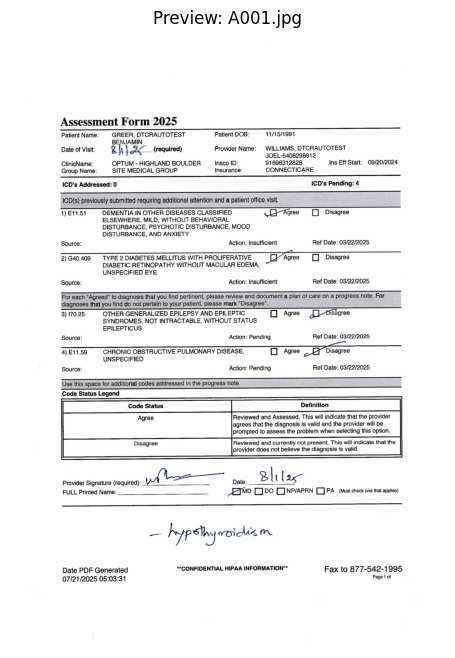

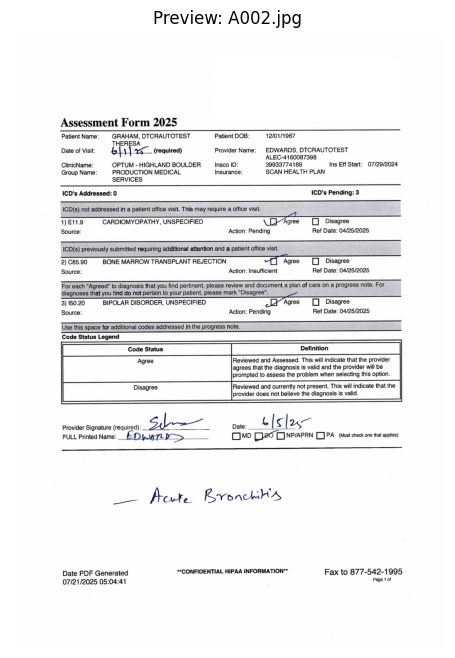

In [3]:
# === Cell AL1: Repo clone, paths, image listing, quick sanity ===
import os, sys, subprocess, importlib, json, re, glob, shutil
from pathlib import Path

# --- directories ---
ROOT      = Path("/content/").resolve()
REPO_DIR = ROOT / "dissertation"
DATA_DIR  = REPO_DIR / "data"              # expected: 74 images + ls_annotation.json
OUT_DIR   = ROOT / "outputs"
CACHE_DIR = ROOT / "cache"

for p in [REPO_DIR, OUT_DIR, CACHE_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# --- clone or pull your repo ---
GIT_URL = "https://github.com/ravanandurai/dissertation.git"
if (REPO_DIR / ".git").exists():
    print("Repo exists, pulling latest...")
    subprocess.check_call(["git", "-C", str(REPO_DIR), "pull", "--quiet"])
else:
    print("Cloning repo...")
    subprocess.check_call(["git", "clone", "--quiet", GIT_URL, str(REPO_DIR)])

# --- resolve paths for images & annotation json ---
IMAGES_DIR_CANDIDATES = [
    DATA_DIR,                 # /content/assessment_repo/data
    REPO_DIR / "dataset",     # fallback if structure changes
    REPO_DIR,                 # worst case: images at repo root
]
IMAGES_DIR = None
for cand in IMAGES_DIR_CANDIDATES:
    if cand.exists():
        # contains jpg/png?
        imgs = sorted([p for p in cand.rglob("*") if p.suffix.lower() in {".jpg",".jpeg",".png"}])
        if len(imgs) >= 1:
            IMAGES_DIR = cand
            break
if IMAGES_DIR is None:
    raise RuntimeError("Could not find images in the repo. Please confirm the image folder path.")

ANN_PATH = IMAGES_DIR / "ls_annotation.json"
print(f"Using IMAGES_DIR: {IMAGES_DIR}")
print(f"Annotation JSON: {ANN_PATH}  (exists={ANN_PATH.exists()})")

# --- list images ---
IMG_EXTS = {".jpg", ".jpeg", ".png"}
ALL_IMAGES = sorted([p for p in IMAGES_DIR.iterdir() if p.suffix.lower() in IMG_EXTS])
if not ALL_IMAGES:
    # broader search one level deeper
    ALL_IMAGES = sorted([p for p in IMAGES_DIR.rglob("*") if p.suffix.lower() in IMG_EXTS])

print(f"Found {len(ALL_IMAGES)} image(s). Sample:")
for p in ALL_IMAGES[:10]:
    print(" -", p.name)

# --- basic sanity: ensure writeable outputs ---
(OUT_DIR / "json").mkdir(parents=True, exist_ok=True)
(OUT_DIR / "figures").mkdir(parents=True, exist_ok=True)
test_file = OUT_DIR / "write_test.ok"
test_file.write_text("ok")
assert test_file.exists(), "Cannot write to outputs directory"
test_file.unlink(missing_ok=True)
print("Output dirs OK:", OUT_DIR)

# --- show 2 thumbnails to eyeball data ---
import matplotlib.pyplot as plt
from PIL import Image

thumbs = ALL_IMAGES[:2] if len(ALL_IMAGES) >= 2 else ALL_IMAGES
if not thumbs:
    raise RuntimeError("No images found to preview. Please check IMAGES_DIR.")

for img_path in thumbs:
    im = Image.open(img_path).convert("RGB")
    plt.figure(figsize=(6,8))
    plt.imshow(im)
    plt.axis("off")
    plt.title(f"Preview: {img_path.name}")
    plt.show()


In [4]:
# === Cell AL2 : OCR module (Doctr 1.x) + repo-local cache + pre-cache all images ===
from pathlib import Path
import json, numpy as np
from PIL import Image
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

# --- repo-local cache (Option B) ---
OCR_CACHE = REPO_DIR / "cache" / "ocr_words"
OCR_CACHE.mkdir(parents=True, exist_ok=True)
print("OCR cache dir:", OCR_CACHE)

# --- load Doctr once ---
print("Loading Doctr OCR model...")
_doctr = ocr_predictor(pretrained=True)  # DBResNet50 + CRNN (default fast)

def _quad_to_bbox(quad):
    """
    Convert Doctr quadrilateral -> [x1,y1,x2,y2] normalized [0,1].
    Falls back gracefully if geometry is already a 4-list.
    """
    try:
        pts = np.asarray(quad, dtype=float)
        xs, ys = pts[:, 0], pts[:, 1]
        return [float(xs.min()), float(ys.min()), float(xs.max()), float(ys.max())]
    except Exception:
        if isinstance(quad, (list, tuple)) and len(quad) == 4:
            return [float(v) for v in quad]
        raise ValueError(f"Unexpected geometry format: {quad}")

def _run_doctr(image_path: Path):
    doc = DocumentFile.from_images(str(image_path))
    result = _doctr(doc)
    words = []
    for page in result.pages:
        for block in page.blocks:
            for line in block.lines:
                for word in line.words:
                    text = (word.value or "").strip()
                    if not text:
                        continue
                    bb = _quad_to_bbox(word.geometry)
                    conf = float(getattr(word, "confidence", 1.0))
                    words.append({"text": text, "bbox": bb, "confidence": conf})
    return words

def ocr_page(image_path: Path, force: bool = False):
    """
    OCR a single page with caching.
      - image_path: Path to .jpg/.png
      - force: True to ignore cache and recompute
    Returns: list of {text, bbox:[x1,y1,x2,y2], confidence}
    """
    cache_file = OCR_CACHE / f"{image_path.stem}.json"
    if cache_file.exists() and not force:
        try:
            return json.loads(cache_file.read_text())
        except Exception:
            pass  # corrupted cache -> recompute

    words = _run_doctr(image_path)
    cache_file.write_text(json.dumps(words, ensure_ascii=False))
    return words

# --- quick smoke on the first 2 images ---
for p in ALL_IMAGES[:2]:
    ws = ocr_page(p)
    print(f"{p.name}: {len(ws)} words extracted. Sample: {ws[:5]}")

# --- pre-cache ALL images now ---
print(f"Pre-caching OCR for {len(ALL_IMAGES)} images ...")
ok, fail = 0, 0
errors = []
for i, p in enumerate(ALL_IMAGES, 1):
    try:
        _ = ocr_page(p)  # uses cache if present
        ok += 1
        if i % 10 == 0 or i == len(ALL_IMAGES):
            print(f"  cached: {ok}/{len(ALL_IMAGES)}")
    except Exception as e:
        fail += 1
        errors.append((p.name, str(e)))
print(f"Done. Cached={ok}, Failed={fail}. Cache dir: {OCR_CACHE}")
if fail:
    print("Failures:")
    for name, err in errors[:5]:
        print(f"  - {name}: {err}")


OCR cache dir: /content/dissertation/cache/ocr_words
Loading Doctr OCR model...
A001.jpg: 274 words extracted. Sample: [{'text': 'Assessment', 'bbox': [0.11464513112152358, 0.1376953125, 0.250002755315397, 0.154296875], 'confidence': 0.9779832363128662}, {'text': 'Form', 'bbox': [0.25414635605602576, 0.1357421875, 0.32320636839983874, 0.154296875], 'confidence': 0.9993388056755066}, {'text': '2025', 'bbox': [0.3259687688935913, 0.1357421875, 0.3853603795092705, 0.154296875], 'confidence': 0.9954209923744202}, {'text': 'Patient', 'bbox': [0.11602633136839985, 0.162109375, 0.16298713976219265, 0.1728515625], 'confidence': 0.9995796084403992}, {'text': 'Name:', 'bbox': [0.16160593951531643, 0.162109375, 0.20718554766223296, 0.1728515625], 'confidence': 0.9949253797531128}]
A002.jpg: 247 words extracted. Sample: [{'text': 'Assessment', 'bbox': [0.11464513112152358, 0.138671875, 0.250002755315397, 0.1552734375], 'confidence': 0.8989742398262024}, {'text': 'Form', 'bbox': [0.2541463560560257

In [5]:
# === Cell L3 (fixed): Parse Label Studio → REGIONS + CHECKBOX_GT (with state) ===
import json, re
from pathlib import Path
from collections import defaultdict

ANN_PATH = IMAGES_DIR / "ls_annotation.json"
#ANN_PATH = "/content/dissertation/data/ls_annotation.json"
assert ANN_PATH.exists(), f"Annotation file not found: {ANN_PATH}"

# Canonical labels (incl. insurance_id, and checkbox presence)
CANON_LABELS = [
    "patient_name",
    "patient_dob",
    "visit_date",
    "provider_name_npi",
    "diagnosis_icd",
    "diagnosis_hcc",
    "handwritten_diagnosis",
    "insurance_id",
    "checkbox_agree",
    "checkbox_disagree",
]

def _norm(s: str) -> str:
    s = s.strip().lower()
    return re.sub(r"[^a-z0-9]+", "", s)

# Synonyms + your exact LS labels
SYNONYMS = {
    "patient_name": ["patient_name","patientname","name","patient-name","patient name"],
    "patient_dob": ["patient_dob","patientdob","dob","dateofbirth","patient-dob","patient dob"],
    "visit_date": ["visit_date","visitdate","dateofservice","dos","visit-date","service_date","service-date","date of visit"],
    "provider_name_npi": ["provider_name_npi","provider","providername","provider-npi","provider name npi","provider_name-and-npi"],
    "diagnosis_icd": ["diagnosis_icd","icd","icd_code","diagnosisicd","dx_icd","icd-code","dx-code"],
    "diagnosis_hcc": ["diagnosis_hcc","hcc","hcc_description","diagnosishcc","hccdesc","hcc-desc"],
    "handwritten_diagnosis": ["handwritten_diagnosis","handwriting","handwritten","free_text","freetext","handwritten-dx"],
    "insurance_id": ["insurance_id","insuranceid"],
    "checkbox_agree": ["checkbox_agree","agree","agree_checkbox","cb_agree","tick_agree"],
    "checkbox_disagree": ["checkbox_disagree","disagree","disagree_checkbox","cb_disagree","tick_disagree"],
}
NORM_TO_CANON = {}
for canon, alts in SYNONYMS.items():
    for a in alts:
        NORM_TO_CANON[_norm(a)] = canon

EXACT_MAP = {
    "Patient_Name": "patient_name",
    "Patient_DOB": "patient_dob",
    "Visit_Date": "visit_date",
    "Provider_Name_NPI": "provider_name_npi",
    "ICD_Code": "diagnosis_icd",
    "HCC_Description": "diagnosis_hcc",
    "Handwritten_Diagnosis": "handwritten_diagnosis",
    "Insurance_ID": "insurance_id",
    "Checkbox_Agree_Checked": "checkbox_agree",
    "Checkbox_Agree_Unchecked": "checkbox_agree",
    "Checkbox_Disagree_Checked": "checkbox_disagree",
    "Checkbox_Disagree_Unchecked": "checkbox_disagree",
}
for raw, canon in EXACT_MAP.items():
    NORM_TO_CANON[_norm(raw)] = canon

def canon_label(ls_label: str):
    return NORM_TO_CANON.get(_norm(ls_label))

# Normalize image keys: lowercase base filename (e.g., a001.jpg)
def img_key(name: str) -> str:
    return Path(name).name.lower()

# Build a map from normalized keys → actual Paths on disk
IMG_KEY2PATH = {img_key(p.name): p for p in ALL_IMAGES}

def extract_image_name(data_dict: dict):
    keys = ["image","img","image_url","ocr","ocr_url","file_upload"]
    for k in keys:
        v = data_dict.get(k)
        if isinstance(v, str) and re.search(r"\.(jpg|jpeg|png)$", v, re.I):
            return img_key(v)
    for v in data_dict.values():
        if isinstance(v, str) and re.search(r"\.(jpg|jpeg|png)$", v, re.I):
            return img_key(v)
    return None

def results_from_task(task: dict):
    for key in ("annotations", "completions", "predictions"):
        lst = task.get(key)
        if isinstance(lst, list) and lst:
            res = lst[0].get("result")
            if isinstance(res, list):
                return res
    res = task.get("result")
    return res if isinstance(res, list) else []

def rect_from_value(val: dict):
    x,y,w,h = val.get("x"), val.get("y"), val.get("width"), val.get("height")
    if None not in (x,y,w,h):
        return [float(x)/100.0, float(y)/100.0, float(x+w)/100.0, float(y+h)/100.0]
    pts = val.get("points") or []
    if pts:
        xs = [float(p["x"]) for p in pts]
        ys = [float(p["y"]) for p in pts]
        return [min(xs)/100.0, min(ys)/100.0, max(xs)/100.0, max(ys)/100.0]
    return None

def labels_from_result(r: dict):
    val = r.get("value", {})
    labels = (val.get("rectanglelabels")
              or val.get("polygonlabels")
              or val.get("labels")
              or val.get("choices"))
    if isinstance(labels, str):
        labels = [labels]
    return labels or []

# IMPORTANT: classify 'unchecked' before 'checked'
def checkbox_state_from_raw(raw: str):
    s = raw.lower()
    if s.endswith("unchecked"):
        return "unchecked"
    if s.endswith("checked"):
        return "checked"
    return "unknown"

# Parse LS
LS = json.loads(ANN_PATH.read_text())
if not isinstance(LS, list):
    raise ValueError("Unexpected ls_annotation.json format (root should be a list)")

REGIONS = defaultdict(lambda: defaultdict(list))  # image_key → {canon: [bboxes]}
CHECKBOX_GT = defaultdict(list)                   # image_key → list of {bbox, kind, state}
seen_raw = set()
task_count = 0

for task in LS:
    task_count += 1
    data = task.get("data", {})
    key = extract_image_name(data)
    if not key:
        for v in task.values():
            if isinstance(v, str) and re.search(r"\.(jpg|jpeg|png)$", v, re.I):
                key = img_key(v); break
    if not key:
        continue

    for r in results_from_task(task):
        val = r.get("value", {})
        labels = labels_from_result(r)
        if not labels:
            continue
        bb = rect_from_value(val)
        if not bb:
            continue
        for raw_lbl in labels:
            seen_raw.add(raw_lbl)
            canon = canon_label(raw_lbl)
            if not canon:
                continue
            REGIONS[key][canon].append(bb)
            if canon in ("checkbox_agree", "checkbox_disagree"):
                CHECKBOX_GT[key].append({
                    "bbox": bb,
                    "kind": "agree" if canon == "checkbox_agree" else "disagree",
                    "state": checkbox_state_from_raw(raw_lbl),
                })

# Summaries
print(f"Parsed {task_count} LS tasks.")
print("Unique raw LS labels observed:", sorted(seen_raw))

coverage = {c: 0 for c in CANON_LABELS}
for key, labs in REGIONS.items():
    for c in CANON_LABELS:
        if labs.get(c):
            coverage[c] += 1

print("\nLabel coverage (images with at least one region):")
for c in CANON_LABELS:
    print(f"  {c:22s}: {coverage[c]:3d} / {len(ALL_IMAGES)}")

total_boxes = sum(len(v) for v in CHECKBOX_GT.values())
checked = sum(1 for v in CHECKBOX_GT.values() for it in v if it["state"] == "checked")
unchecked = sum(1 for v in CHECKBOX_GT.values() for it in v if it["state"] == "unchecked")
print(f"\nCheckbox GT: {total_boxes} boxes across {len(CHECKBOX_GT)} images "
      f"(checked={checked}, unchecked={unchecked})")

# Choose a sample image that actually exists in REGIONS and on disk
sample_key = next((k for k in REGIONS.keys() if k in IMG_KEY2PATH), None)
if sample_key:
    print(f"\nSample regions for {sample_key}:")
    for c in CANON_LABELS:
        if REGIONS[sample_key].get(c):
            print(f"  {c}: {len(REGIONS[sample_key][c])} box(es)  eg: {REGIONS[sample_key][c][:2]}")
    print(f"\nSample checkbox GT for {sample_key}:", CHECKBOX_GT.get(sample_key, [])[:4])
else:
    print("\nNo overlap between LS image names and files on disk after normalization. Double-check filenames.")


Parsed 74 LS tasks.
Unique raw LS labels observed: ['Checkbox_Agree_Checked', 'Checkbox_Agree_Unchecked', 'Checkbox_Disagree_Checked', 'Checkbox_Disagree_Unchecked', 'HCC_Description', 'Handwritten_Diagnosis', 'ICD_Code', 'Insurance_ID', 'Patient_DOB', 'Patient_Name', 'Provider_Name_NPI', 'Visit_Date']

Label coverage (images with at least one region):
  patient_name          :  74 / 74
  patient_dob           :  74 / 74
  visit_date            :  74 / 74
  provider_name_npi     :  74 / 74
  diagnosis_icd         :  74 / 74
  diagnosis_hcc         :  74 / 74
  handwritten_diagnosis :  58 / 74
  insurance_id          :  74 / 74
  checkbox_agree        :  74 / 74
  checkbox_disagree     :  74 / 74

Checkbox GT: 557 boxes across 74 images (checked=274, unchecked=283)

No overlap between LS image names and files on disk after normalization. Double-check filenames.


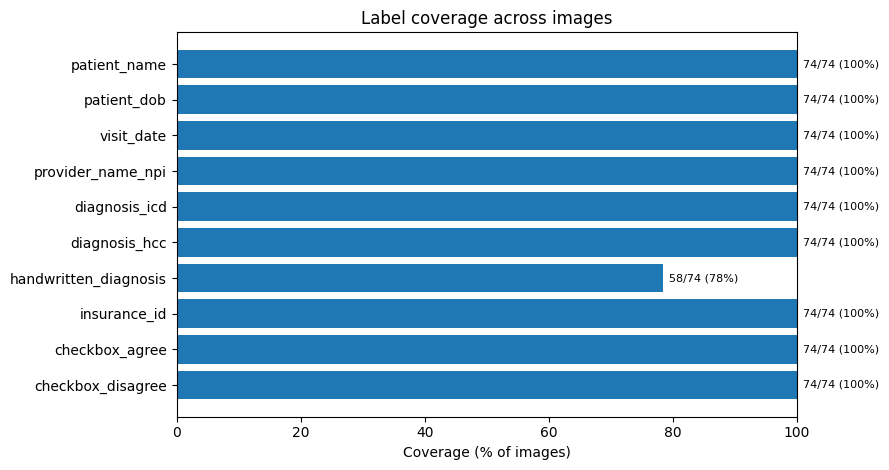

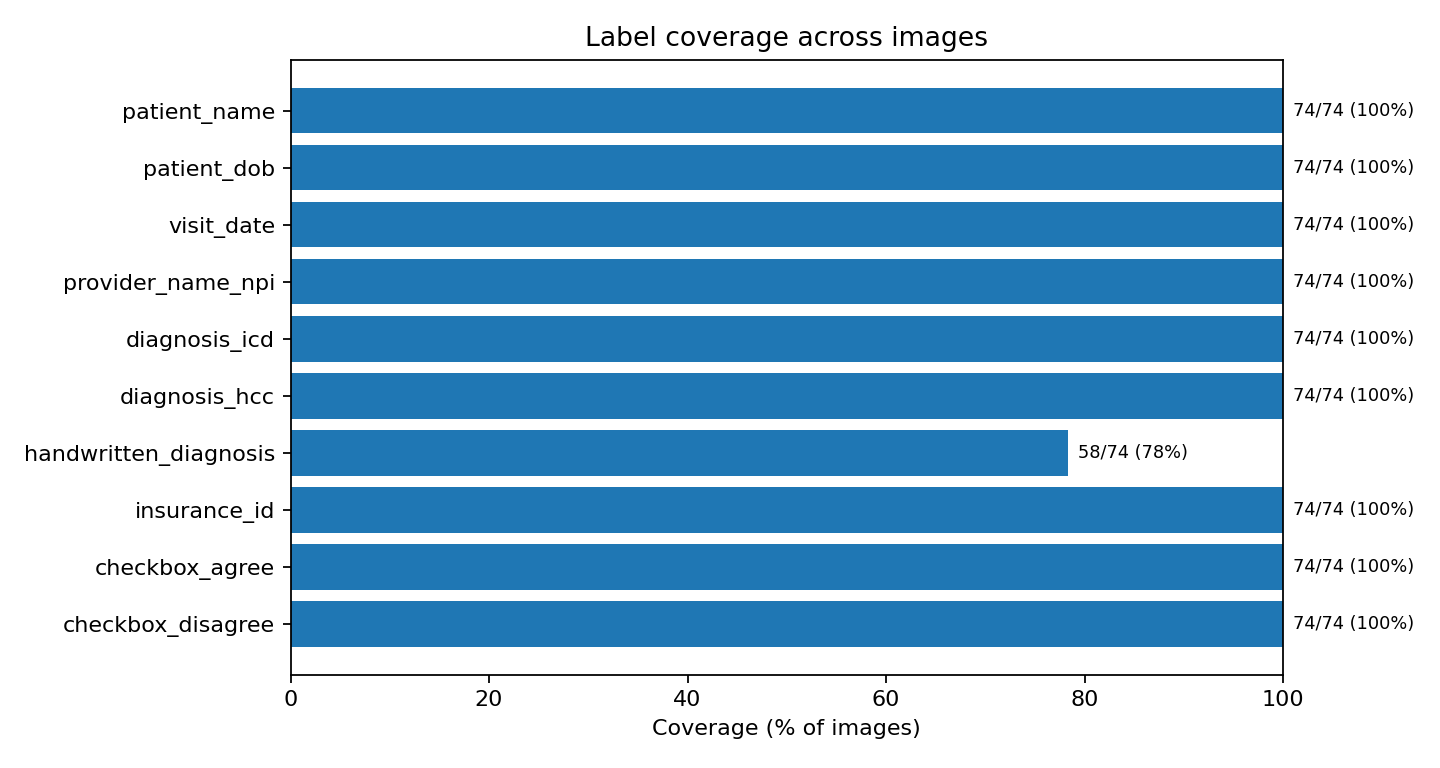

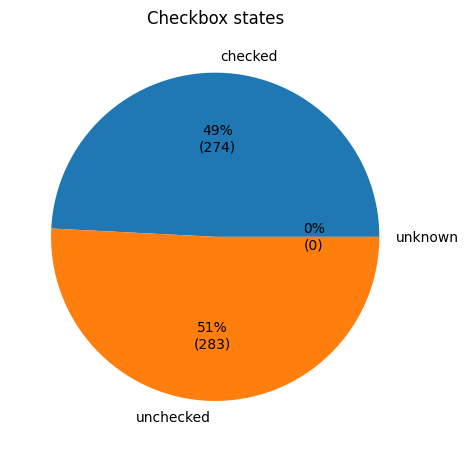

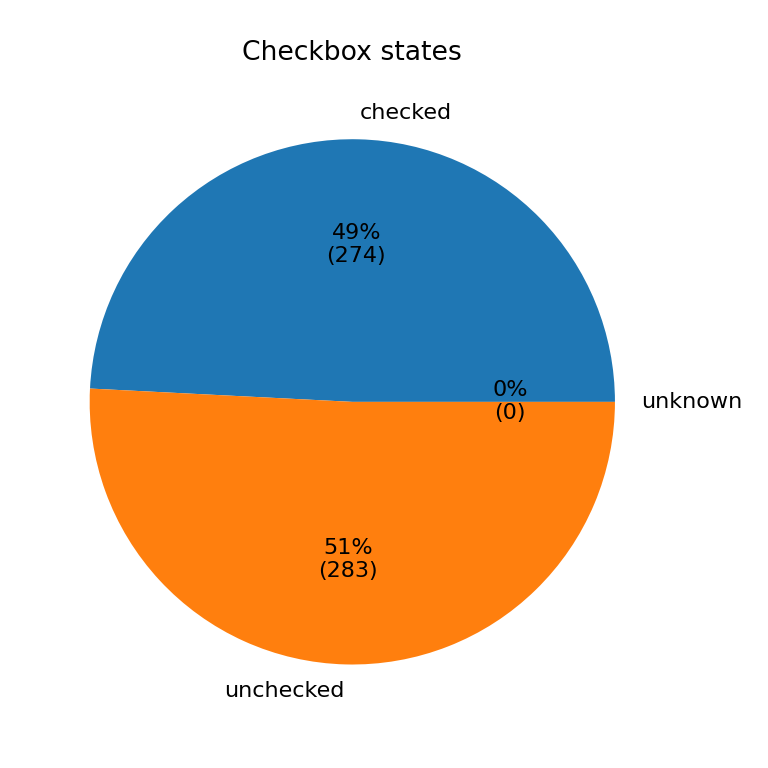

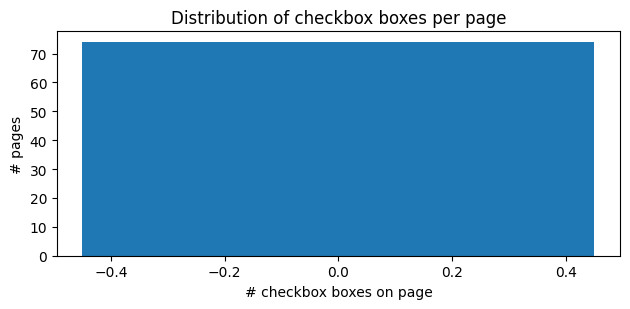

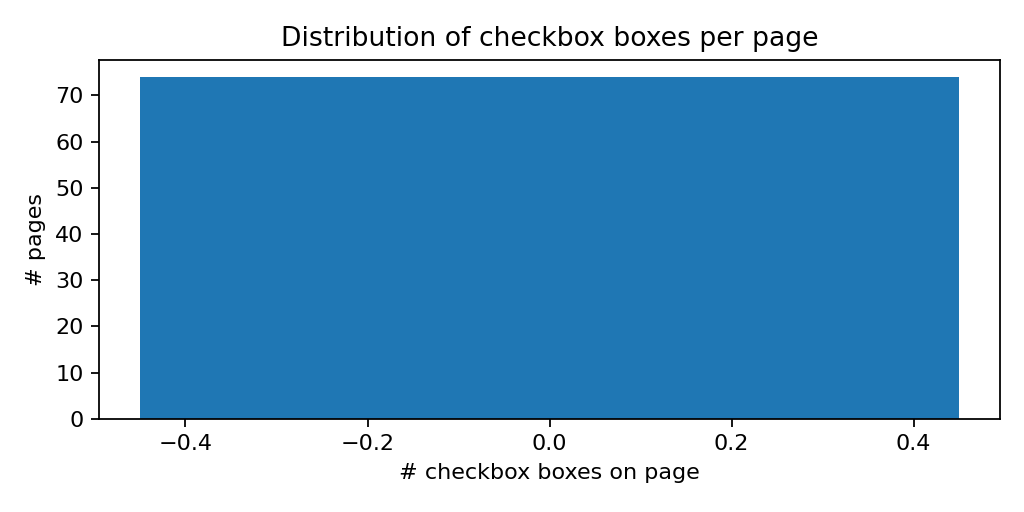

Saved figures to: /content/outputs/figures


In [7]:
# === Cell L3.viz: Label Studio summaries — plots + boxed previews ===
import math, json
from pathlib import Path
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import cv2
from IPython.display import display, Image as IPyImage

FIG_DIR = OUT_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# ---- 1) Coverage bar chart ----
labels = CANON_LABELS
counts = [sum(1 for k in REGIONS if REGIONS[k].get(c)) for c in labels]
total  = len(ALL_IMAGES)
pct    = [100.0 * c / max(1, total) for c in counts]

fig, ax = plt.subplots(figsize=(9, 4.8))
y = np.arange(len(labels))
ax.barh(y, pct)
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_xlim(0, 100)
ax.set_xlabel("Coverage (% of images)")
ax.set_title("Label coverage across images")
for i, v in enumerate(pct):
    ax.text(v + 1, i, f"{counts[i]}/{total} ({v:.0f}%)", va="center", fontsize=8)
cov_path = FIG_DIR / "ls_coverage.png"
plt.tight_layout()
plt.savefig(cov_path, dpi=160)
plt.show()
display(IPyImage(filename=str(cov_path)))

# ---- 2) Checkbox distribution (checked vs unchecked) ----
checked = sum(1 for v in CHECKBOX_GT.values() for it in v if it["state"] == "checked")
unchecked = sum(1 for v in CHECKBOX_GT.values() for it in v if it["state"] == "unchecked")
unknown = sum(1 for v in CHECKBOX_GT.values() for it in v if it["state"] not in ("checked","unchecked"))
vals = np.array([checked, unchecked, unknown], dtype=float)
labels2 = ["checked", "unchecked", "unknown"]
# avoid empty wedges rendering warning
vals_plot = vals if vals.sum() > 0 else np.array([1, 0, 0], dtype=float)

fig, ax = plt.subplots(figsize=(4.8, 4.8))
ax.pie(vals_plot, labels=labels2, autopct=lambda p: f"{p:.0f}%\n({int(round(p/100*vals.sum()))})" if vals.sum() else "0")
ax.set_title("Checkbox states")
chk_path = FIG_DIR / "ls_checkbox_pie.png"
plt.tight_layout()
plt.savefig(chk_path, dpi=160)
plt.show()
display(IPyImage(filename=str(chk_path)))

# ---- 3) Per-image checkbox counts (small histogram) ----
per_img = [len(CHECKBOX_GT.get(k, [])) for k in sorted(IMG_KEY2PATH.keys())]
fig, ax = plt.subplots(figsize=(6.4, 3.2))
ax.hist(per_img, bins=range(0, max(per_img or [1])+2), align="left", rwidth=0.9)
ax.set_xlabel("# checkbox boxes on page")
ax.set_ylabel("# pages")
ax.set_title("Distribution of checkbox boxes per page")
hist_path = FIG_DIR / "ls_checkbox_hist.png"
plt.tight_layout()
plt.savefig(hist_path, dpi=160)
plt.show()
display(IPyImage(filename=str(hist_path)))

# ---- 4) Preview: draw boxes for a few sample pages ----
# Simple palette
PALETTE = {
    "patient_name": (60, 180, 75),
    "patient_dob": (255, 225, 25),
    "visit_date": (0, 130, 200),
    "provider_name_npi": (245, 130, 48),
    "insurance_id": (145, 30, 180),
    "diagnosis_icd": (70, 240, 240),
    "diagnosis_hcc": (230, 25, 75),
    "handwritten_diagnosis": (240, 50, 230),
    "checkbox_agree": (0, 0, 255),
    "checkbox_disagree": (255, 0, 0),
}

def draw_boxes(img_path: Path, regions: dict, out_path: Path, thickness=2):
    im = cv2.imread(str(img_path))
    if im is None:
        return
    h, w = im.shape[:2]
    # draw regions
    for canon, boxes in regions.items():
        color = PALETTE.get(canon, (200, 200, 200))
        for (x1, y1, x2, y2) in boxes:
            p1 = (int(x1*w), int(y1*h))
            p2 = (int(x2*w), int(y2*h))
            cv2.rectangle(im, p1, p2, color, thickness)
            cv2.putText(im, canon, (p1[0], max(15, p1[1]-4)), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 1, cv2.LINE_AA)
    cv2.imwrite(str(out_path), im)

# pick up to 4 good examples that exist both in REGIONS and on disk
examples = [k for k in sorted(REGIONS.keys()) if k in IMG_KEY2PATH][:4]
grid_imgs = []
for k in examples:
    src = IMG_KEY2PATH[k]
    dst = FIG_DIR / f"preview_{Path(k).stem}.png"
    draw_boxes(src, REGIONS[k], dst)
    if dst.exists():
        grid_imgs.append(dst)

# display a simple grid
if grid_imgs:
    cols = 2
    rows = math.ceil(len(grid_imgs)/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(12, rows*6))
    axes = np.array(axes).reshape(rows, cols)
    for i, ax in enumerate(axes.flat):
        ax.axis("off")
        if i < len(grid_imgs):
            ax.set_title(grid_imgs[i].name)
            ax.imshow(plt.imread(str(grid_imgs[i])))
    grid_path = FIG_DIR / "ls_previews_grid.png"
    plt.tight_layout()
    plt.savefig(grid_path, dpi=140)
    plt.show()
    display(IPyImage(filename=str(grid_path)))

print("Saved figures to:", FIG_DIR)


Parsed 74 LS tasks. Missing-key tasks: 0
LS keys: 74 | Disk keys: 74 | Intersection: 74
Sample LS keys: ['a001.jpg', 'a002.jpg', 'a003.jpg', 'a004.jpg', 'a005.jpg']

Label coverage (images with at least one region):
  patient_name          :  74 / 74
  patient_dob           :  74 / 74
  visit_date            :  74 / 74
  provider_name_npi     :  74 / 74
  diagnosis_icd         :  74 / 74
  diagnosis_hcc         :  74 / 74
  handwritten_diagnosis :  58 / 74
  insurance_id          :  74 / 74
  checkbox_agree        :  74 / 74
  checkbox_disagree     :  74 / 74

Checkbox GT: 557 boxes across 74 images (checked=274, unchecked=283)

Sample regions for a001.jpg:
  patient_name: 1 box(es)  eg: [[0.23151027064015686, 0.16049809617605304, 0.40739794378884747, 0.18388192475799456]]
  patient_dob: 1 box(es)  eg: [[0.5817823034918227, 0.15837229357769475, 0.656947975777588, 0.17325291176620294]]
  visit_date: 1 box(es)  eg: [[0.22700033030301095, 0.18388192475799456, 0.32621901772022105, 0.200888

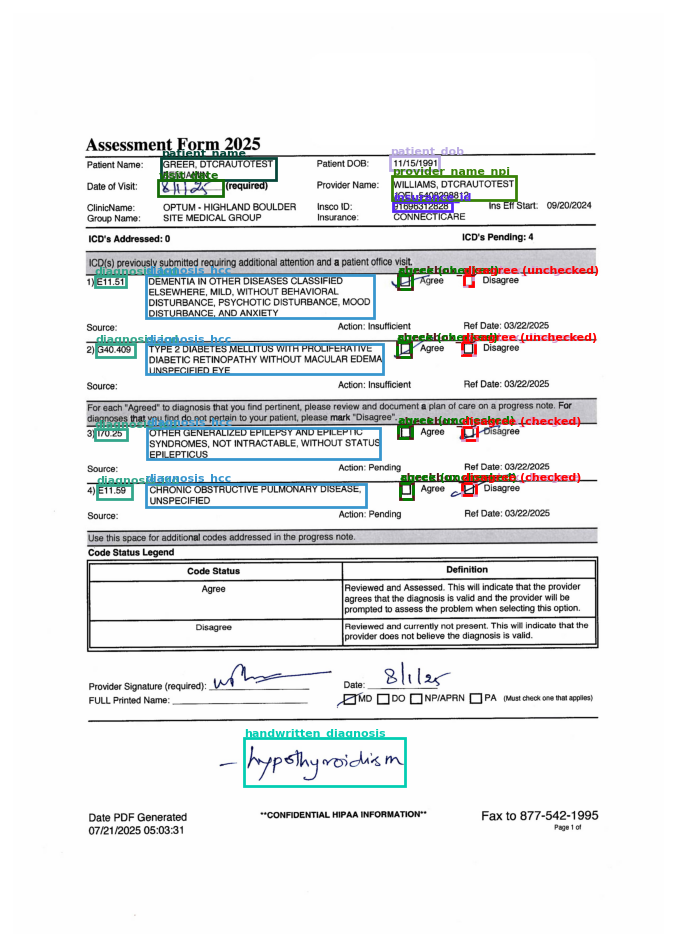

In [8]:
# === Cell AL3 (final): Parse Label Studio → REGIONS + CHECKBOX_GT with canonical image mapping ===
import json, re
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

ANN_PATH = IMAGES_DIR / "ls_annotation.json"
assert ANN_PATH.exists(), f"Annotation file not found: {ANN_PATH}"

# Canonical labels (incl. insurance_id, and checkbox presence)
CANON_LABELS = [
    "patient_name",
    "patient_dob",
    "visit_date",
    "provider_name_npi",
    "diagnosis_icd",
    "diagnosis_hcc",
    "handwritten_diagnosis",
    "insurance_id",
    "checkbox_agree",
    "checkbox_disagree",
]

def _norm(s: str) -> str:
    s = s.strip().lower()
    return re.sub(r"[^a-z0-9]+", "", s)

# Synonyms + your exact LS labels
SYNONYMS = {
    "patient_name": ["patient_name","patientname","name","patient-name","patient name","patient_name_npi"],  # last is just defensive
    "patient_dob": ["patient_dob","patientdob","dob","dateofbirth","patient-dob","patient dob"],
    "visit_date": ["visit_date","visitdate","dateofservice","dos","visit-date","service_date","service-date","date of visit"],
    "provider_name_npi": ["provider_name_npi","provider","providername","provider-npi","provider name npi","provider_name-and-npi"],
    "diagnosis_icd": ["diagnosis_icd","icd","icd_code","diagnosisicd","dx_icd","icd-code","dx-code"],
    "diagnosis_hcc": ["diagnosis_hcc","hcc","hcc_description","diagnosishcc","hccdesc","hcc-desc"],
    "handwritten_diagnosis": ["handwritten_diagnosis","handwriting","handwritten","free_text","freetext","handwritten-dx"],
    "insurance_id": ["insurance_id","insuranceid"],
    "checkbox_agree": ["checkbox_agree","agree","agree_checkbox","cb_agree","tick_agree"],
    "checkbox_disagree": ["checkbox_disagree","disagree","disagree_checkbox","cb_disagree","tick_disagree"],
}
NORM_TO_CANON = {}
for canon, alts in SYNONYMS.items():
    for a in alts:
        NORM_TO_CANON[_norm(a)] = canon

EXACT_MAP = {
    "Patient_Name": "patient_name",
    "Patient_DOB": "patient_dob",
    "Visit_Date": "visit_date",
    "Provider_Name_NPI": "provider_name_npi",
    "ICD_Code": "diagnosis_icd",
    "HCC_Description": "diagnosis_hcc",
    "Handwritten_Diagnosis": "handwritten_diagnosis",
    "Insurance_ID": "insurance_id",
    "Checkbox_Agree_Checked": "checkbox_agree",
    "Checkbox_Agree_Unchecked": "checkbox_agree",
    "Checkbox_Disagree_Checked": "checkbox_disagree",
    "Checkbox_Disagree_Unchecked": "checkbox_disagree",
}
for raw, canon in EXACT_MAP.items():
    NORM_TO_CANON[_norm(raw)] = canon

def canon_label(ls_label: str):
    return NORM_TO_CANON.get(_norm(ls_label))

# Normalize disk filenames → lowercase
def disk_key(name: str) -> str:
    return Path(name).name.lower()

IMG_KEY2PATH = {disk_key(p.name): p for p in ALL_IMAGES}

# --- NEW: canonical name extractor: "*-A###.jpg" -> "a###.jpg"
A_CODE_RE = re.compile(r"(?:^|[-_])((?:a)\d{3}\.(?:jpg|jpeg|png))$", re.I)
def canonical_page_name(value: str) -> str | None:
    """
    Extract 'A###.jpg' from LS file name strings like 'ffb616d3-A069.jpg'.
    Returns lowercase 'a###.jpg' or None if not found.
    """
    if not isinstance(value, str):
        return None
    m = A_CODE_RE.search(value.strip())
    if m:
        return m.group(1).lower()
    return None

def extract_image_key(task: dict) -> str | None:
    """
    Prefer file_upload if present; fallback to data.image, then any string in task.
    Returns lowercase 'a###.jpg' key if derivable, else None.
    """
    # 1) direct fields
    if "file_upload" in task:
        k = canonical_page_name(task["file_upload"])
        if k: return k
    data = task.get("data", {})
    if isinstance(data, dict) and "image" in data:
        k = canonical_page_name(data["image"])
        if k: return k
    # 2) scan all string values
    for v in [task.get("file_upload")] + list(data.values()) + list(task.values()):
        if isinstance(v, str):
            k = canonical_page_name(v)
            if k: return k
    return None

def results_from_task(task: dict):
    for key in ("annotations", "completions", "predictions"):
        lst = task.get(key)
        if isinstance(lst, list) and lst:
            res = lst[0].get("result")
            if isinstance(res, list):
                return res
    res = task.get("result")
    return res if isinstance(res, list) else []

def rect_from_value(val: dict):
    x,y,w,h = val.get("x"), val.get("y"), val.get("width"), val.get("height")
    if None not in (x,y,w,h):
        return [float(x)/100.0, float(y)/100.0, float(x+w)/100.0, float(y+h)/100.0]
    pts = val.get("points") or []
    if pts:
        xs = [float(p["x"]) for p in pts]
        ys = [float(p["y"]) for p in pts]
        return [min(xs)/100.0, min(ys)/100.0, max(xs)/100.0, max(ys)/100.0]
    return None

def labels_from_result(r: dict):
    val = r.get("value", {})
    labels = (val.get("rectanglelabels")
              or val.get("polygonlabels")
              or val.get("labels")
              or val.get("choices"))
    if isinstance(labels, str):
        labels = [labels]
    return labels or []

def checkbox_state_from_raw(raw: str):
    s = raw.lower()
    if s.endswith("unchecked"):
        return "unchecked"
    if s.endswith("checked"):
        return "checked"
    return "unknown"

# --------------------------- Parse LS with canonical keys ---------------------------
LS = json.loads(ANN_PATH.read_text())
if not isinstance(LS, list):
    raise ValueError("Unexpected ls_annotation.json format (root should be a list)")

REGIONS = defaultdict(lambda: defaultdict(list))  # key 'a###.jpg' -> {canon: [bboxes]}
CHECKBOX_GT = defaultdict(list)                   # key 'a###.jpg' -> list of {bbox, kind, state}
seen_raw = set()
task_count = 0
missing_key = 0

for task in LS:
    task_count += 1
    key = extract_image_key(task)
    if not key:
        missing_key += 1
        continue

    for r in results_from_task(task):
        val = r.get("value", {})
        labels = labels_from_result(r)
        if not labels:
            continue
        bb = rect_from_value(val)
        if not bb:
            continue
        for raw_lbl in labels:
            seen_raw.add(raw_lbl)
            canon = canon_label(raw_lbl)
            if not canon:
                continue
            REGIONS[key][canon].append(bb)
            if canon in ("checkbox_agree", "checkbox_disagree"):
                CHECKBOX_GT[key].append({
                    "bbox": bb,
                    "kind": "agree" if canon == "checkbox_agree" else "disagree",
                    "state": checkbox_state_from_raw(raw_lbl),
                })

# ------------------------------ Summaries ------------------------------------
ls_keys = set(REGIONS.keys())
disk_keys = set(IMG_KEY2PATH.keys())
intersect = sorted(ls_keys & disk_keys)

print(f"Parsed {task_count} LS tasks. Missing-key tasks: {missing_key}")
print(f"LS keys: {len(ls_keys)} | Disk keys: {len(disk_keys)} | Intersection: {len(intersect)}")
print("Sample LS keys:", intersect[:5] if intersect else list(sorted(ls_keys))[:5])

print("\nLabel coverage (images with at least one region):")
coverage = {c: 0 for c in CANON_LABELS}
for k, labs in REGIONS.items():
    for c in CANON_LABELS:
        if labs.get(c):
            coverage[c] += 1
for c in CANON_LABELS:
    print(f"  {c:22s}: {coverage[c]:3d} / {len(disk_keys)}")

total_boxes = sum(len(v) for v in CHECKBOX_GT.values())
checked = sum(1 for v in CHECKBOX_GT.values() for it in v if it["state"] == "checked")
unchecked = sum(1 for v in CHECKBOX_GT.values() for it in v if it["state"] == "unchecked")
print(f"\nCheckbox GT: {total_boxes} boxes across {len(CHECKBOX_GT)} images "
      f"(checked={checked}, unchecked={unchecked})")

# Show a sample page that actually overlaps
sample_key = intersect[0] if intersect else None
if sample_key:
    print(f"\nSample regions for {sample_key}:")
    for c in CANON_LABELS:
        if REGIONS[sample_key].get(c):
            print(f"  {c}: {len(REGIONS[sample_key][c])} box(es)  eg: {REGIONS[sample_key][c][:2]}")
    print(f"\nSample checkbox GT for {sample_key}:", CHECKBOX_GT.get(sample_key, [])[:4])
else:
    print("\nNo overlap yet — if this persists, please share a couple of task entries to inspect.")


# ------------------------------ Visualise sample image ------------------------------------
sample_key = intersect[0] if intersect else None
if sample_key:
    print(f"\nSample regions for {sample_key}:")
    for c in CANON_LABELS:
        if REGIONS[sample_key].get(c):
            print(f"  {c}: {len(REGIONS[sample_key][c])} box(es)  eg: {REGIONS[sample_key][c][:2]}")
    print(f"\nSample checkbox GT for {sample_key}:", CHECKBOX_GT.get(sample_key, [])[:4])

    img_path = IMG_KEY2PATH[sample_key]
    img = plt.imread(img_path)

    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(img)
    ax.axis("off")

    # Assign random colors to each label for consistency
    label_colors = {c: (random.random(), random.random(), random.random()) for c in CANON_LABELS}

    # Draw normal label boxes
    for label, bboxes in REGIONS[sample_key].items():
        for bbox in bboxes:
            x1, y1, x2, y2 = bbox
            w = x2 - x1
            h = y2 - y1
            ax.add_patch(patches.Rectangle(
                (x1 * img.shape[1], y1 * img.shape[0]),
                w * img.shape[1],
                h * img.shape[0],
                linewidth=2,
                edgecolor=label_colors[label],
                facecolor='none',
                label=label
            ))
            ax.text(x1 * img.shape[1], y1 * img.shape[0] - 5, label, color=label_colors[label],
                    fontsize=8, weight='bold')

    # Draw checkbox boxes separately in fixed colors
    for cb in CHECKBOX_GT[sample_key]:
        x1, y1, x2, y2 = cb["bbox"]
        edgecolor = "green" if cb["kind"] == "agree" else "red"
        ax.add_patch(patches.Rectangle(
            (x1 * img.shape[1], y1 * img.shape[0]),
            (x2 - x1) * img.shape[1],
            (y2 - y1) * img.shape[0],
            linewidth=2,
            edgecolor=edgecolor,
            facecolor='none',
            linestyle="--"
        ))
        ax.text(x1 * img.shape[1], y1 * img.shape[0] - 5, f"{cb['kind']} ({cb['state']})",
                color=edgecolor, fontsize=8, weight='bold')

    plt.show()
else:
    print("\nNo overlap yet — cannot show sample image.")


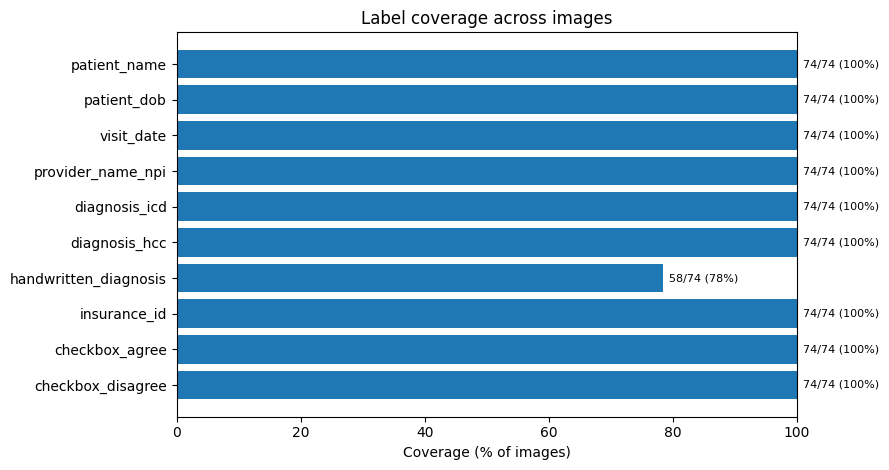

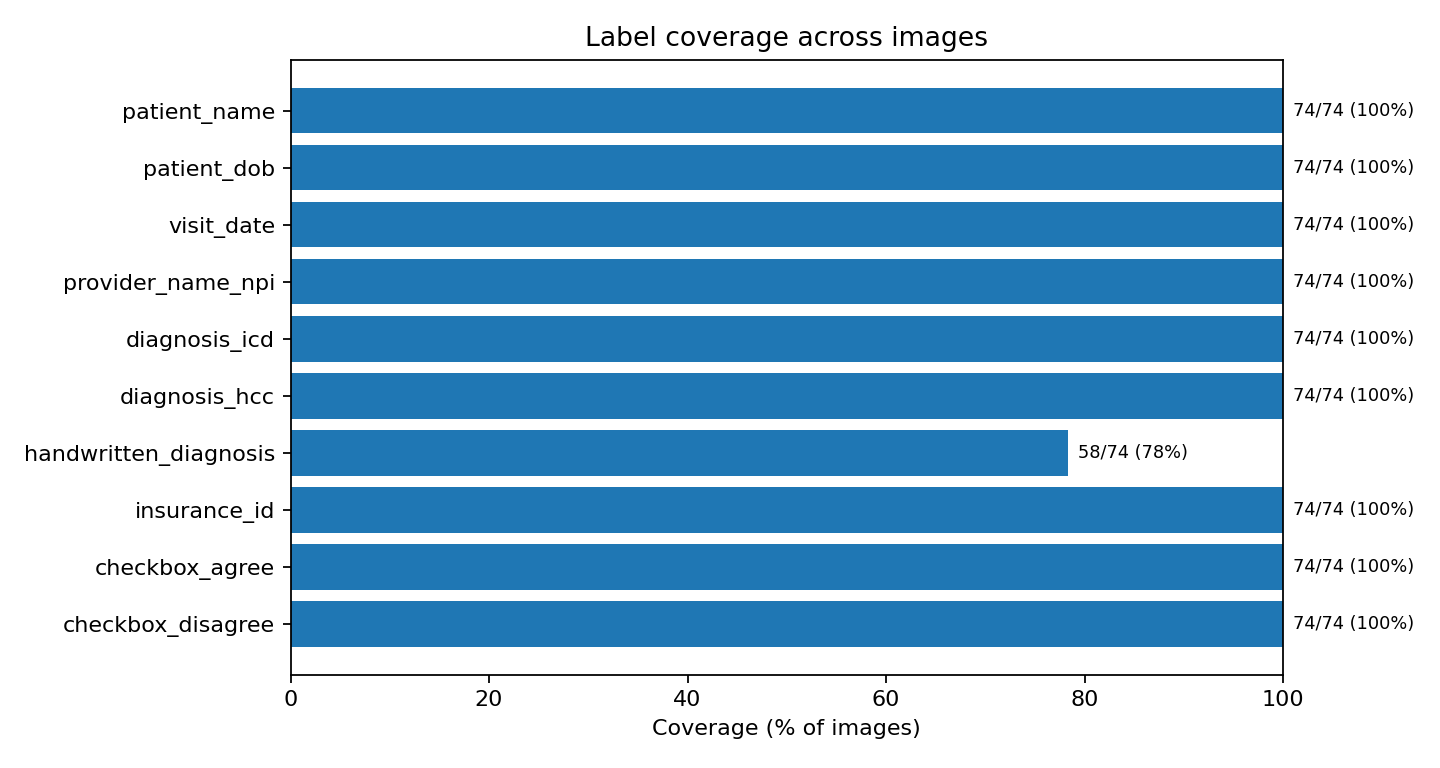

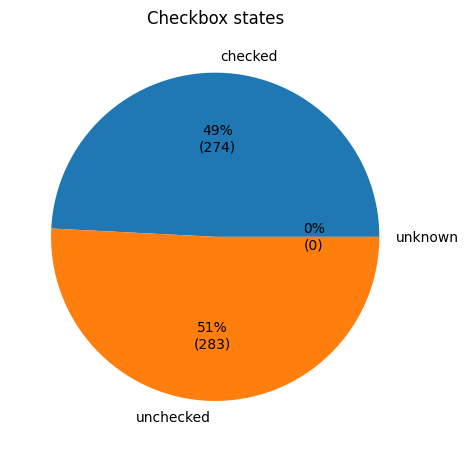

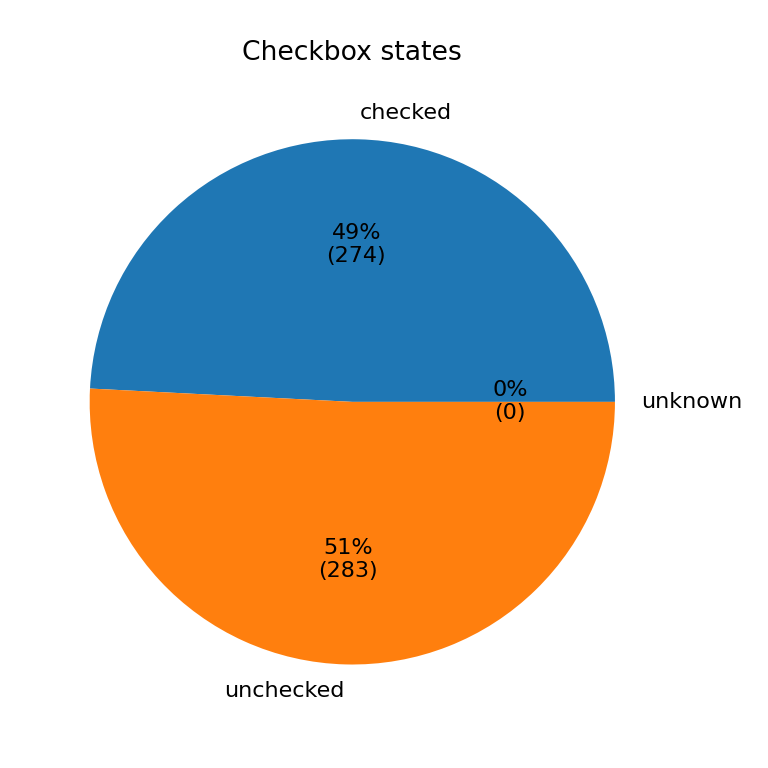

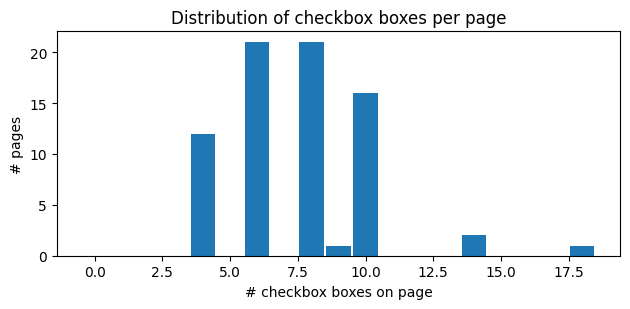

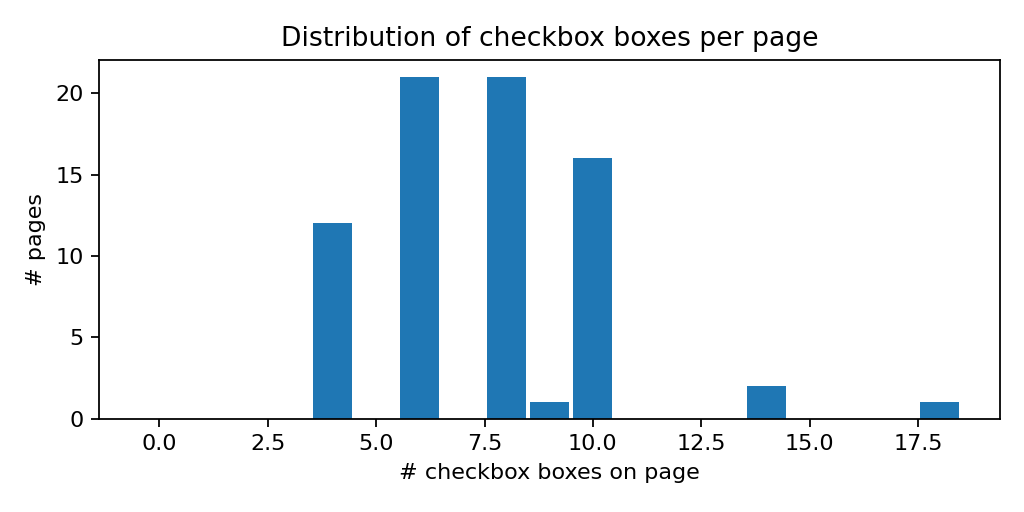

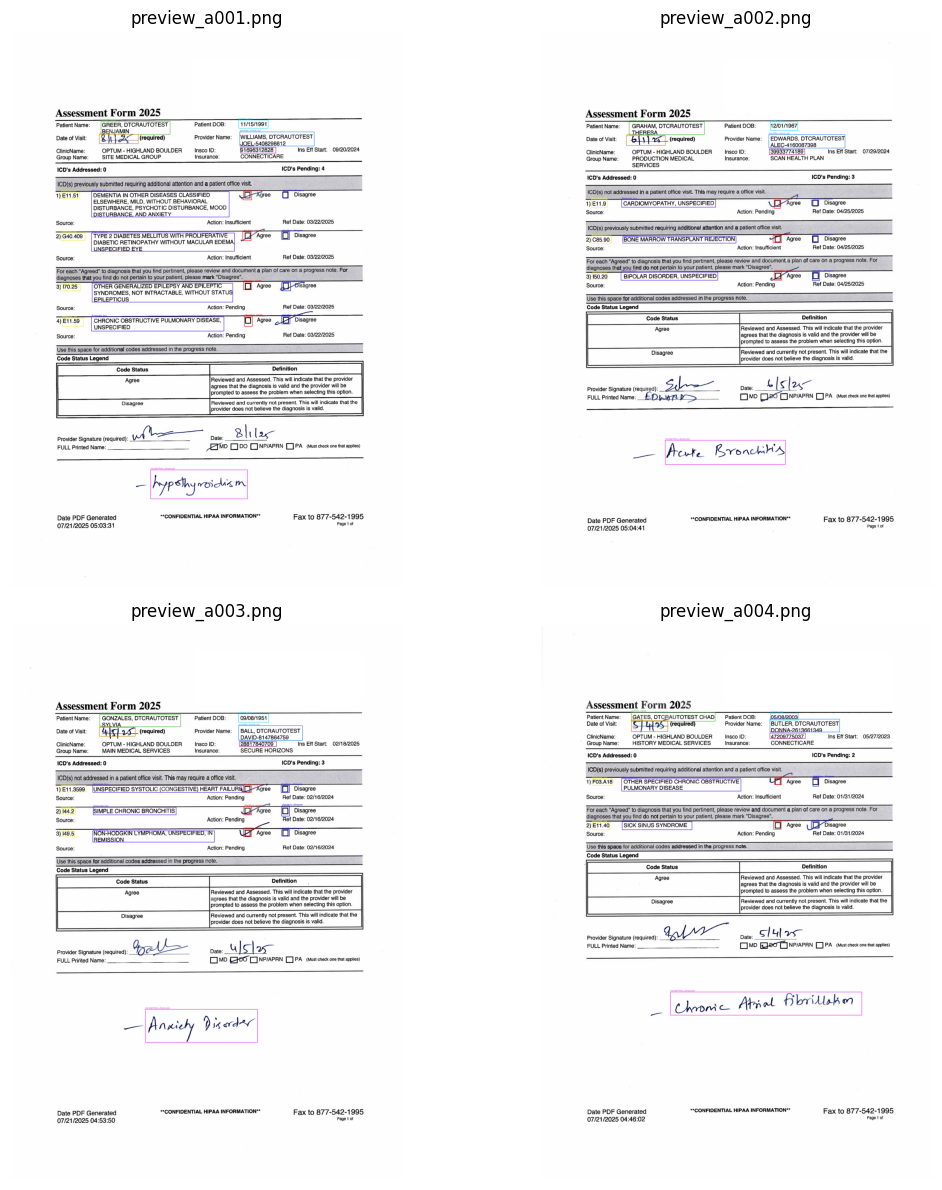

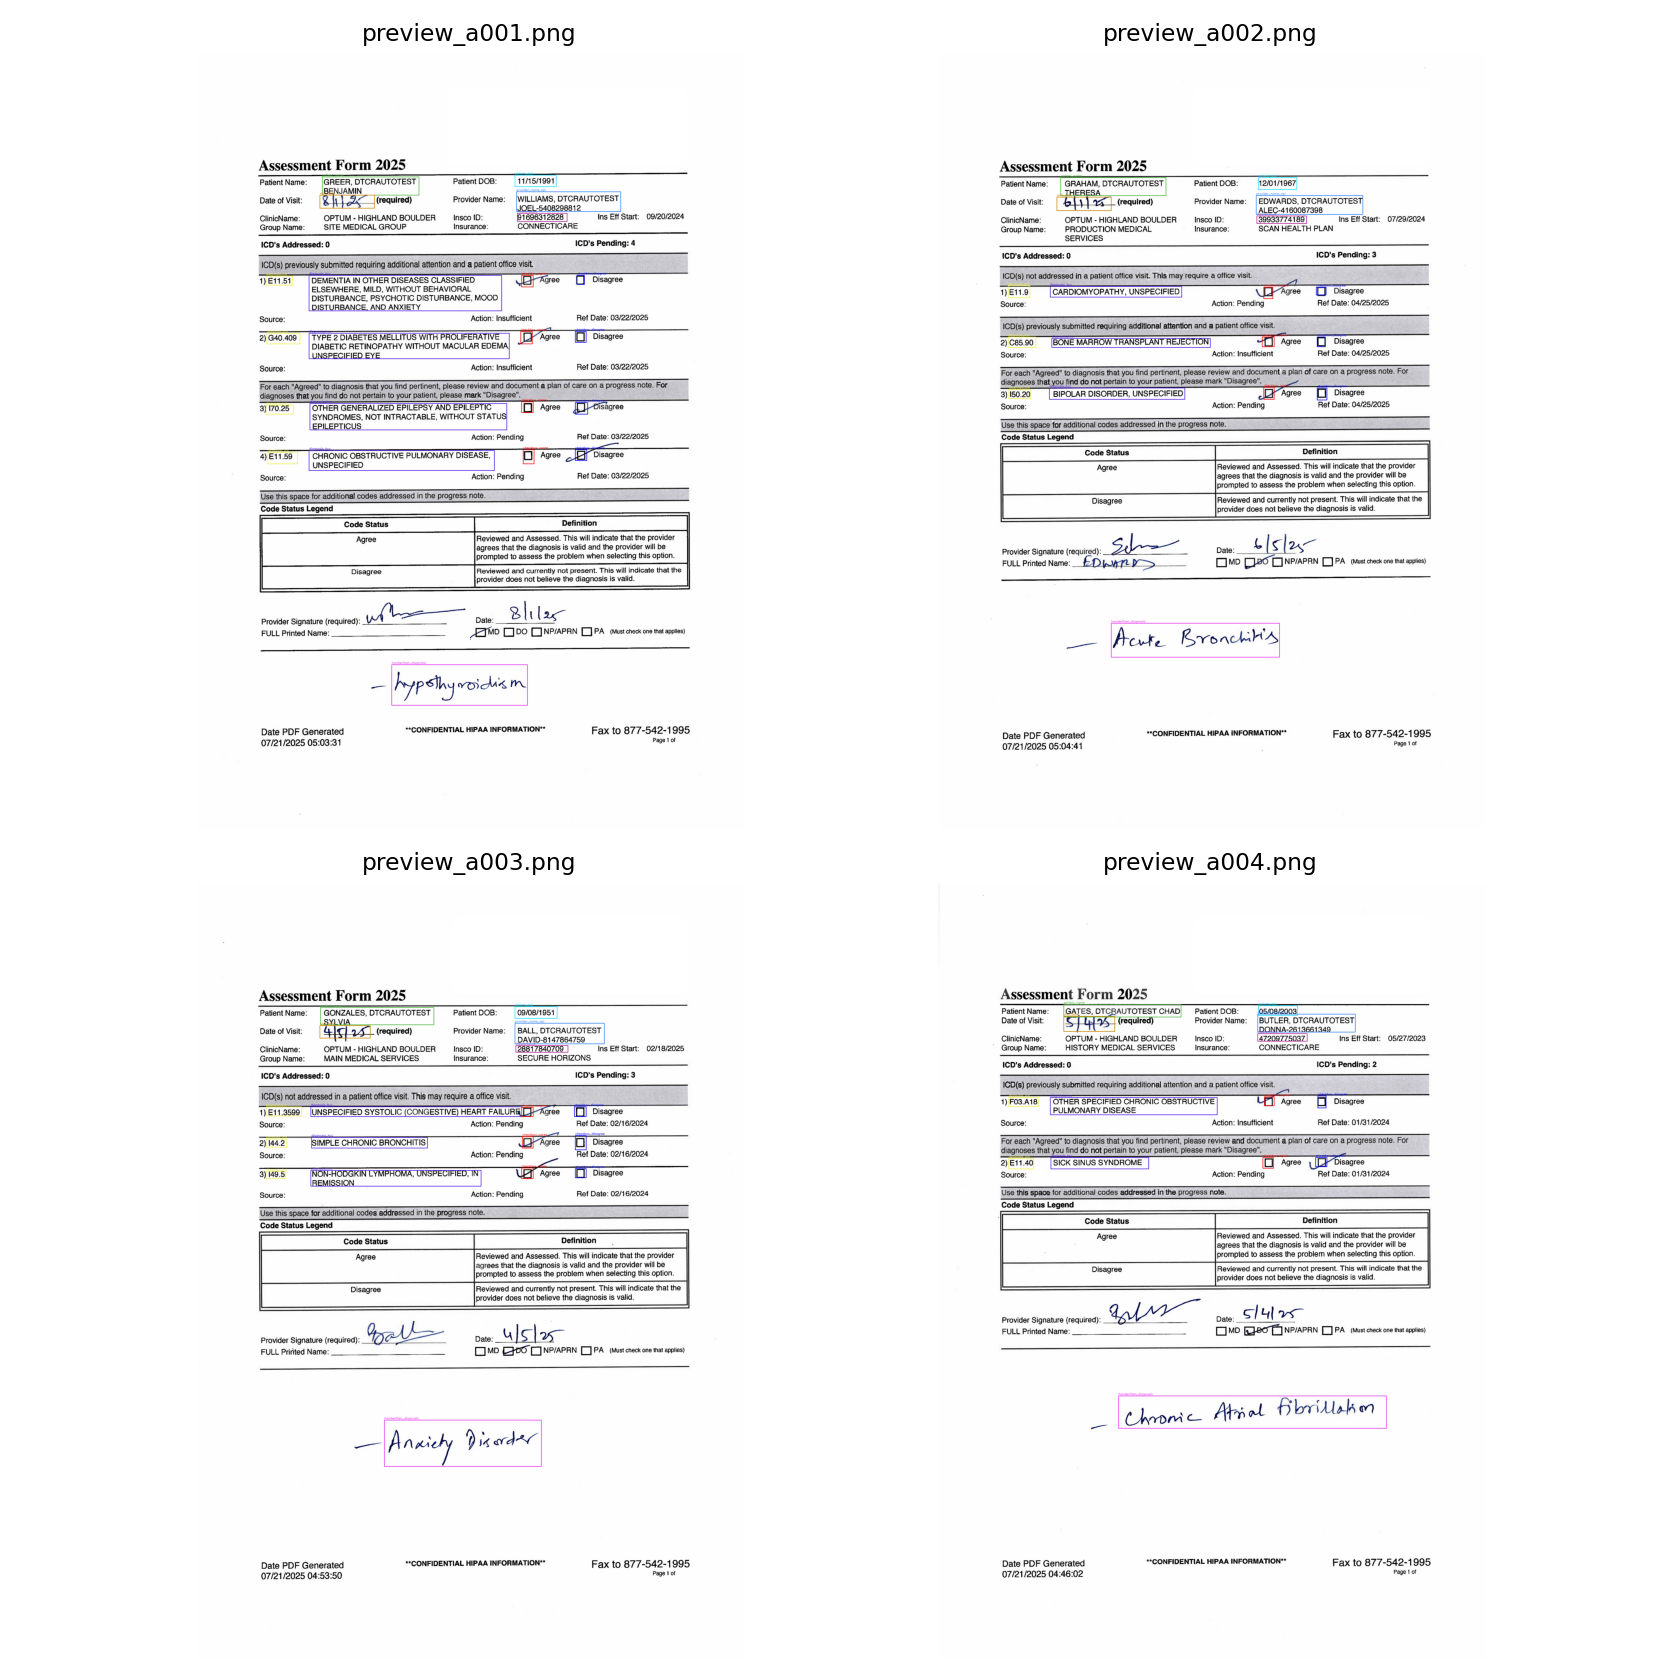

Saved figures to: /content/outputs/figures


In [9]:
# === Cell L3.viz: Label Studio summaries — plots + boxed previews ===
import math, json
from pathlib import Path
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import cv2
from IPython.display import display, Image as IPyImage

FIG_DIR = OUT_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# ---- 1) Coverage bar chart ----
labels = CANON_LABELS
counts = [sum(1 for k in REGIONS if REGIONS[k].get(c)) for c in labels]
total  = len(ALL_IMAGES)
pct    = [100.0 * c / max(1, total) for c in counts]

fig, ax = plt.subplots(figsize=(9, 4.8))
y = np.arange(len(labels))
ax.barh(y, pct)
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_xlim(0, 100)
ax.set_xlabel("Coverage (% of images)")
ax.set_title("Label coverage across images")
for i, v in enumerate(pct):
    ax.text(v + 1, i, f"{counts[i]}/{total} ({v:.0f}%)", va="center", fontsize=8)
cov_path = FIG_DIR / "ls_coverage.png"
plt.tight_layout()
plt.savefig(cov_path, dpi=160)
plt.show()
display(IPyImage(filename=str(cov_path)))

# ---- 2) Checkbox distribution (checked vs unchecked) ----
checked = sum(1 for v in CHECKBOX_GT.values() for it in v if it["state"] == "checked")
unchecked = sum(1 for v in CHECKBOX_GT.values() for it in v if it["state"] == "unchecked")
unknown = sum(1 for v in CHECKBOX_GT.values() for it in v if it["state"] not in ("checked","unchecked"))
vals = np.array([checked, unchecked, unknown], dtype=float)
labels2 = ["checked", "unchecked", "unknown"]
# avoid empty wedges rendering warning
vals_plot = vals if vals.sum() > 0 else np.array([1, 0, 0], dtype=float)

fig, ax = plt.subplots(figsize=(4.8, 4.8))
ax.pie(vals_plot, labels=labels2, autopct=lambda p: f"{p:.0f}%\n({int(round(p/100*vals.sum()))})" if vals.sum() else "0")
ax.set_title("Checkbox states")
chk_path = FIG_DIR / "ls_checkbox_pie.png"
plt.tight_layout()
plt.savefig(chk_path, dpi=160)
plt.show()
display(IPyImage(filename=str(chk_path)))

# ---- 3) Per-image checkbox counts (small histogram) ----
per_img = [len(CHECKBOX_GT.get(k, [])) for k in sorted(IMG_KEY2PATH.keys())]
fig, ax = plt.subplots(figsize=(6.4, 3.2))
ax.hist(per_img, bins=range(0, max(per_img or [1])+2), align="left", rwidth=0.9)
ax.set_xlabel("# checkbox boxes on page")
ax.set_ylabel("# pages")
ax.set_title("Distribution of checkbox boxes per page")
hist_path = FIG_DIR / "ls_checkbox_hist.png"
plt.tight_layout()
plt.savefig(hist_path, dpi=160)
plt.show()
display(IPyImage(filename=str(hist_path)))

# ---- 4) Preview: draw boxes for a few sample pages ----
# Simple palette
PALETTE = {
    "patient_name": (60, 180, 75),
    "patient_dob": (255, 225, 25),
    "visit_date": (0, 130, 200),
    "provider_name_npi": (245, 130, 48),
    "insurance_id": (145, 30, 180),
    "diagnosis_icd": (70, 240, 240),
    "diagnosis_hcc": (230, 25, 75),
    "handwritten_diagnosis": (240, 50, 230),
    "checkbox_agree": (0, 0, 255),
    "checkbox_disagree": (255, 0, 0),
}

def draw_boxes(img_path: Path, regions: dict, out_path: Path, thickness=2):
    im = cv2.imread(str(img_path))
    if im is None:
        return
    h, w = im.shape[:2]
    # draw regions
    for canon, boxes in regions.items():
        color = PALETTE.get(canon, (200, 200, 200))
        for (x1, y1, x2, y2) in boxes:
            p1 = (int(x1*w), int(y1*h))
            p2 = (int(x2*w), int(y2*h))
            cv2.rectangle(im, p1, p2, color, thickness)
            cv2.putText(im, canon, (p1[0], max(15, p1[1]-4)), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 1, cv2.LINE_AA)
    cv2.imwrite(str(out_path), im)

# pick up to 4 good examples that exist both in REGIONS and on disk
examples = [k for k in sorted(REGIONS.keys()) if k in IMG_KEY2PATH][:4]
grid_imgs = []
for k in examples:
    src = IMG_KEY2PATH[k]
    dst = FIG_DIR / f"preview_{Path(k).stem}.png"
    draw_boxes(src, REGIONS[k], dst)
    if dst.exists():
        grid_imgs.append(dst)

# display a simple grid
if grid_imgs:
    cols = 2
    rows = math.ceil(len(grid_imgs)/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(12, rows*6))
    axes = np.array(axes).reshape(rows, cols)
    for i, ax in enumerate(axes.flat):
        ax.axis("off")
        if i < len(grid_imgs):
            ax.set_title(grid_imgs[i].name)
            ax.imshow(plt.imread(str(grid_imgs[i])))
    grid_path = FIG_DIR / "ls_previews_grid.png"
    plt.tight_layout()
    plt.savefig(grid_path, dpi=140)
    plt.show()
    display(IPyImage(filename=str(grid_path)))

print("Saved figures to:", FIG_DIR)


In [10]:
# === Cell L4 (Code1): Build LayoutLMv3 dataset from OCR + LS (incl. insurance_id) ===
import json, random
from pathlib import Path
from collections import Counter
from PIL import Image

from datasets import Dataset, DatasetDict
from transformers import LayoutLMv3Processor

random.seed(42)

# ---- helpers from earlier cells ----
def img_key(name: str) -> str:
    return Path(name).name.lower()

assert 'REGIONS' in globals(), "Run Cell L3 first (REGIONS missing)"
assert 'ALL_IMAGES' in globals(), "Run Cell L1 first (ALL_IMAGES missing)"
assert 'REPO_DIR' in globals(), "Run Cell L1 first (REPO_DIR missing)"

OCR_DIR = REPO_DIR / "cache" / "ocr_words"
assert OCR_DIR.exists(), f"OCR cache folder not found: {OCR_DIR} (run Cell L2)"

def load_ocr_words(img_path: Path):
    cache_file = OCR_DIR / f"{img_path.stem}.json"
    if not cache_file.exists():
        raise FileNotFoundError(f"OCR cache missing for {img_path.name}: {cache_file}")
    return json.loads(cache_file.read_text())

def norm_boxes_01_to_1000(bb01):
    x1,y1,x2,y2 = bb01
    return [
        max(0, min(1000, int(x1 * 1000))),
        max(0, min(1000, int(y1 * 1000))),
        max(0, min(1000, int(x2 * 1000))),
        max(0, min(1000, int(y2 * 1000))),
    ]

def words_to_tokens_and_boxes(words):
    tokens = [w["text"] for w in words]
    boxes  = [norm_boxes_01_to_1000(w["bbox"]) for w in words]
    return tokens, boxes

def center_in_region(bb1000, reg01):
    cx = (bb1000[0] + bb1000[2]) / 2 / 1000.0
    cy = (bb1000[1] + bb1000[3]) / 2 / 1000.0
    return (reg01[0] <= cx <= reg01[2]) and (reg01[1] <= cy <= reg01[3])

# ---- entity fields & labels (incl. insurance_id) ----
ENTITY_FIELDS = [
    "patient_name",
    "patient_dob",
    "visit_date",
    "provider_name_npi",
    "diagnosis_icd",
    "diagnosis_hcc",
    "handwritten_diagnosis",
    "insurance_id",
]
LABELS = ["O"] + [tag for f in ENTITY_FIELDS for tag in (f"B-{f}", f"I-{f}")]
label2id = {l: i for i, l in enumerate(LABELS)}
id2label = {i: l for l, i in label2id.items()}

# ---- LS↔disk intersection ----
IMG_KEY2PATH = {img_key(p.name): p for p in ALL_IMAGES}
ls_keys   = set(REGIONS.keys())
disk_keys = set(IMG_KEY2PATH.keys())
intersect = sorted(ls_keys & disk_keys)
print(f"LS images: {len(ls_keys)} | Disk images: {len(disk_keys)} | Intersection: {len(intersect)}")

# ---- assign BIO labels per word via center-in-region ----
def assign_bio_labels(word_boxes, region_dict):
    tags = ["O"] * len(word_boxes)
    for field in ENTITY_FIELDS:
        for reg in region_dict.get(field, []):
            idxs = [i for i, bb in enumerate(word_boxes) if center_in_region(bb, reg)]
            if not idxs:
                continue
            idxs.sort()
            for j, i_tok in enumerate(idxs):
                tags[i_tok] = ("B-" if j == 0 else "I-") + field
    return tags

# ---- build examples ----
examples = []
for key in intersect:
    img_path = IMG_KEY2PATH[key]
    words = load_ocr_words(img_path)
    tokens, boxes = words_to_tokens_and_boxes(words)
    bio_tags = assign_bio_labels(boxes, REGIONS[key])
    examples.append({
        "image_path": str(img_path),
        "words": tokens,                # per-word tokens
        "boxes": boxes,                 # per-word boxes [0..1000]
        "word_labels": [label2id[t] for t in bio_tags],  # per-word label ids
    })
print(f"Prepared {len(examples)} examples.")

# ---- processor & encoding (word_labels -> subword alignment handled for us) ----
processor = LayoutLMv3Processor.from_pretrained(
    "microsoft/layoutlmv3-base",
    apply_ocr=False
)

def encode_batch(batch):
    enc = processor(
        images=[Image.open(p).convert("RGB") for p in batch["image_path"]],
        text=batch["words"],
        boxes=batch["boxes"],
        word_labels=batch["word_labels"],
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt",
    )
    enc["image_path"] = batch["image_path"]  # keep for debugging
    return enc

raw_ds = Dataset.from_list(examples)

# ---- split & encode ----
idx = list(range(len(raw_ds)))
random.shuffle(idx)
cut = int(0.8 * len(idx))
train_idx, val_idx = idx[:cut], idx[cut:]

ds = DatasetDict({
    "train": raw_ds.select(train_idx),
    "validation": raw_ds.select(val_idx),
})

print("Encoding train split...")
enc_train = ds["train"].map(
    encode_batch, batched=True, remove_columns=ds["train"].column_names, batch_size=4
)
print("Encoding val split...")
enc_val = ds["validation"].map(
    encode_batch, batched=True, remove_columns=ds["validation"].column_names, batch_size=4
)
enc_ds = DatasetDict({"train": enc_train, "validation": enc_val})
print(enc_ds)

# ---- quick sanity: label distribution & a non-O sample ----
def label_dist(dset):
    c = Counter()
    for row in dset:
        for lid in row["labels"]:
            if lid != -100:
                c[id2label[lid]] += 1
    return c

print("\nLabel distribution (train) — top 12:")
for k,v in sorted(label_dist(enc_ds["train"]).items(), key=lambda x: -x[1])[:12]:
    print(f"  {k:28s} {v}")

for row in enc_ds["validation"]:
    labs = [id2label[lid] for lid in row["labels"] if lid != -100]
    if any(l != "O" for l in labs):
        print("\nSample image:", row["image_path"])
        print("First 40 non-O labels:", labs[:40])
        break


LS images: 74 | Disk images: 74 | Intersection: 74
Prepared 74 examples.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Encoding train split...


Map:   0%|          | 0/59 [00:00<?, ? examples/s]

Encoding val split...


Map:   0%|          | 0/15 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_path', 'input_ids', 'attention_mask', 'bbox', 'labels', 'pixel_values'],
        num_rows: 59
    })
    validation: Dataset({
        features: ['image_path', 'input_ids', 'attention_mask', 'bbox', 'labels', 'pixel_values'],
        num_rows: 15
    })
})

Label distribution (train) — top 12:
  O                            12254
  I-diagnosis_hcc              1086
  B-diagnosis_icd              230
  B-diagnosis_hcc              226
  I-provider_name_npi          115
  I-patient_name               107
  I-handwritten_diagnosis      67
  B-patient_name               59
  B-patient_dob                59
  B-provider_name_npi          59
  B-insurance_id               59
  B-visit_date                 57

Sample image: /content/dissertation/data/A033.jpg
First 40 non-O labels: ['O', 'O', 'O', 'O', 'O', 'B-patient_name', 'I-patient_name', 'I-patient_name', 'O', 'O', 'B-patient_dob', 'O', 'O', 'O', 'B-visit_date', 'O', 'O', 'O', 

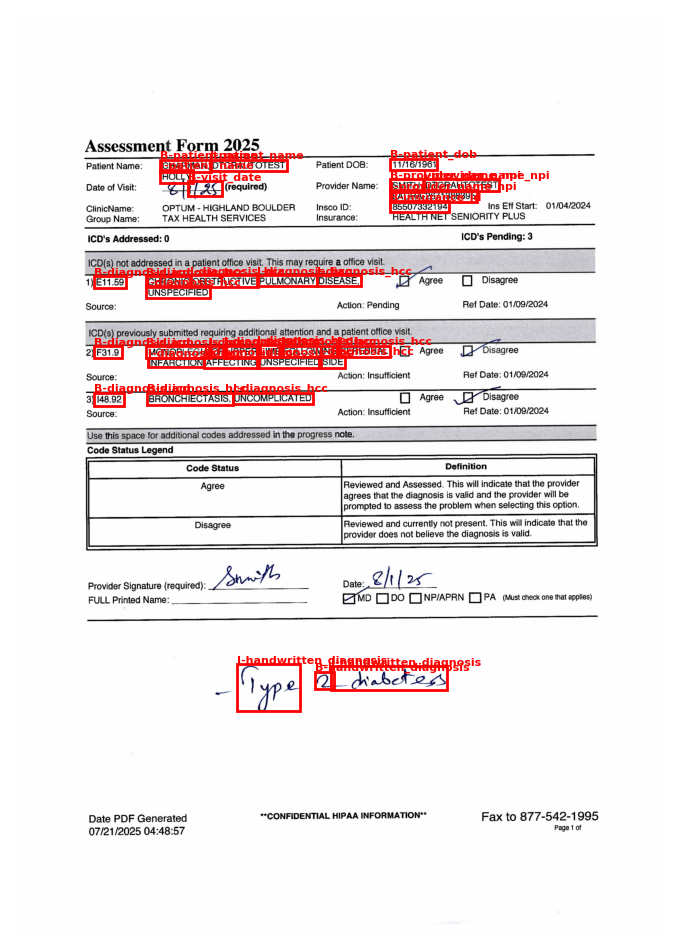

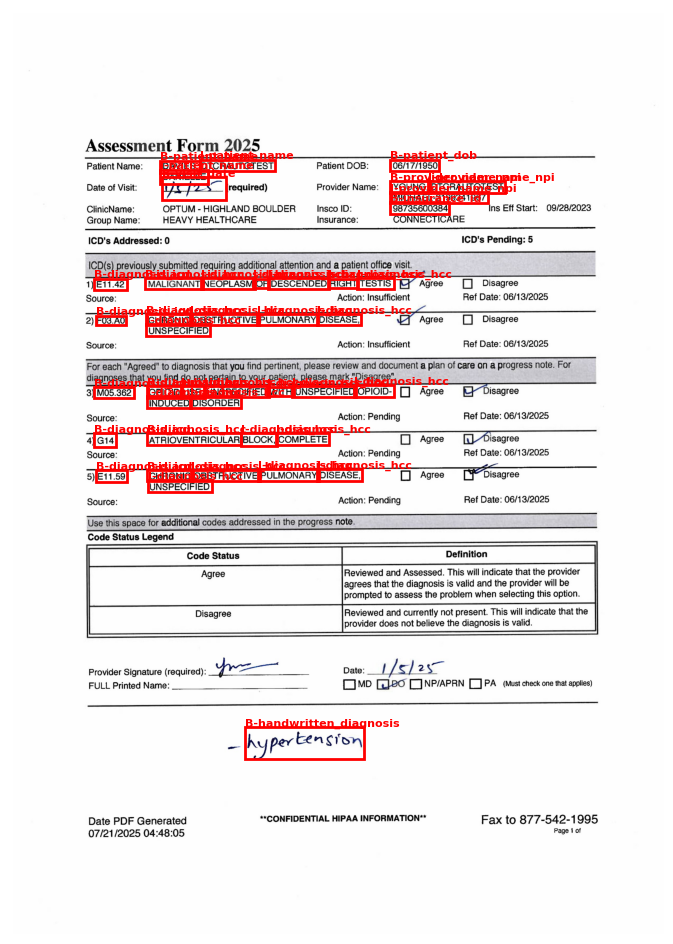

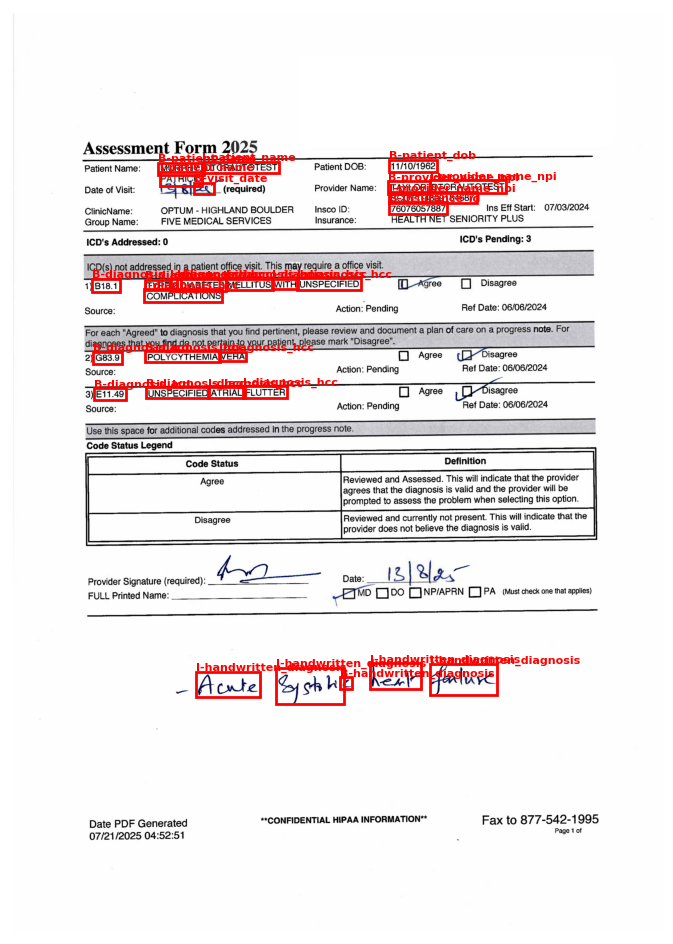

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

def show_labeled_image(example):
    img = Image.open(example["image_path"])
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(img)
    ax.axis("off")

    for word, box, lab in zip(example["words"], example["boxes"], example["word_labels"]):
        label = id2label[lab]
        if label == "O":
            continue
        x1, y1, x2, y2 = [v / 1000 * img.size[i % 2] for i, v in enumerate(box)]
        ax.add_patch(patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor="red", facecolor="none"
        ))
        ax.text(x1, y1 - 3, label, fontsize=8, color="red", weight="bold")

    plt.show()

# Pick 3 random samples from train
for sample in random.sample(examples, 3):
    show_labeled_image(sample)


In [12]:
# === Cell AL5 (final): Train LayoutLMv3 (token classification) ===
import os, math, numpy as np, torch, random
from pathlib import Path
from transformers import (
    LayoutLMv3ForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification,
    EarlyStoppingCallback,
    set_seed,
)
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

# Reuse globals:
# - enc_ds (DatasetDict with 'train' and 'validation')
# - LABELS, id2label, label2id
# - OUT_DIR
# - processor (from Cell L4)

set_seed(42)

MODEL_DIR = (OUT_DIR / "models" / "layoutlmv3_fieldtagger").resolve()
MODEL_DIR.mkdir(parents=True, exist_ok=True)

num_labels = len(LABELS)
model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

# Use the processor's tokenizer so labels/padding align
data_collator = DataCollatorForTokenClassification(tokenizer=processor.tokenizer)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=-1)
    labels = p.label_ids

    true_labels, true_preds = [], []
    for pred_seq, label_seq in zip(preds, labels):
        y_true, y_pred = [], []
        for p_i, l_i in zip(pred_seq, label_seq):
            if l_i == -100:
                continue
            y_true.append(id2label[int(l_i)])
            y_pred.append(id2label[int(p_i)])
        true_labels.append(y_true)
        true_preds.append(y_pred)

    return {
        "precision": precision_score(true_labels, true_preds),
        "recall":    recall_score(true_labels, true_preds),
        "f1":        f1_score(true_labels, true_preds),
    }

args = TrainingArguments(
    output_dir=str(MODEL_DIR),
    eval_strategy="epoch",            # clearer API; logs each epoch
    save_strategy="epoch",
    logging_strategy="epoch",         # per-epoch training loss (no more "No log")
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=2,    # effective batch size 4
    num_train_epochs=12,              # a bit longer; early stopping will stop sooner if stable
    learning_rate=3e-5,               # slightly lower LR for stability
    weight_decay=0.01,
    warmup_ratio=0.1,
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
    dataloader_num_workers=2,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=enc_ds["train"],
    eval_dataset=enc_ds["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

print("Starting training…")
train_out = trainer.train()
print("Best model checkpoint:", trainer.state.best_model_checkpoint)

# Evaluate on validation
eval_metrics = trainer.evaluate()
print("Eval metrics:", eval_metrics)

# Detailed seqeval report
pred = trainer.predict(enc_ds["validation"])
pred_ids = np.argmax(pred.predictions, axis=-1)

true_labels, true_preds = [], []
for pred_seq, label_seq in zip(pred_ids, pred.label_ids):
    y_true, y_pred = [], []
    for p_i, l_i in zip(pred_seq, label_seq):
        if l_i == -100:
            continue
        y_true.append(id2label[int(l_i)])
        y_pred.append(id2label[int(p_i)])
    true_labels.append(y_true)
    true_preds.append(y_pred)

print("\nSeqEval classification report:\n")
print(classification_report(true_labels, true_preds, digits=4))

# Save best model + processor
trainer.save_model(str(MODEL_DIR))
processor.save_pretrained(str(MODEL_DIR))
print(f"\nSaved best model and processor to: {MODEL_DIR}")


Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training…


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Tra

Best model checkpoint: /content/outputs/models/layoutlmv3_fieldtagger/checkpoint-150


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Eval metrics: {'eval_loss': 0.033418525010347366, 'eval_precision': 0.9672897196261683, 'eval_recall': 0.971830985915493, 'eval_f1': 0.9695550351288057, 'eval_runtime': 2.2311, 'eval_samples_per_second': 6.723, 'eval_steps_per_second': 3.586, 'epoch': 12.0}

SeqEval classification report:

                       precision    recall  f1-score   support

        diagnosis_hcc     1.0000    1.0000    1.0000        70
        diagnosis_icd     1.0000    0.9800    0.9899        50
handwritten_diagnosis     0.8000    0.7273    0.7619        11
         insurance_id     1.0000    1.0000    1.0000        15
          patient_dob     1.0000    1.0000    1.0000        15
         patient_name     1.0000    1.0000    1.0000        22
    provider_name_npi     1.0000    1.0000    1.0000        15
           visit_date     0.7222    0.8667    0.7879        15

            micro avg     0.9673    0.9718    0.9696       213
            macro avg     0.9403    0.9467    0.9425       213
         weigh

Using trainer_state: /content/outputs/models/layoutlmv3_fieldtagger/checkpoint-90/trainer_state.json


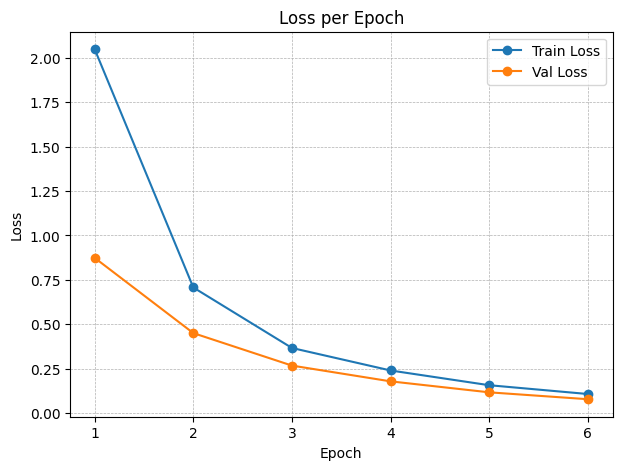

Saved: /content/outputs/figures/loss_curves.png


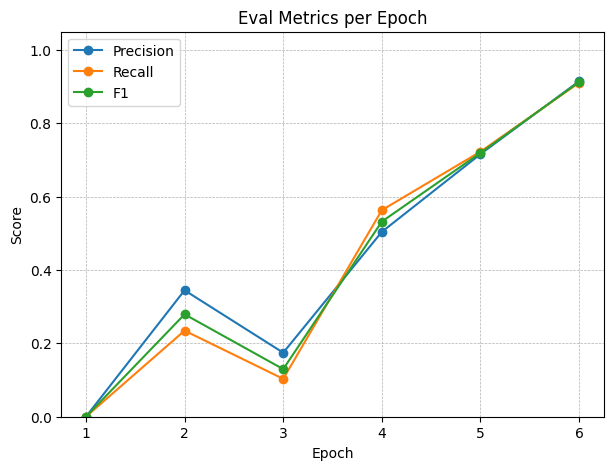

Saved: /content/outputs/figures/eval_metrics.png

Epoch | Val Loss | Val F1
    1 | 0.874087 | 0.0000
    2 | 0.450679 | 0.2793
    3 | 0.267922 | 0.1298
    4 | 0.179246 | 0.5322
    5 | 0.117493 | 0.7196
    6 | 0.078711 | 0.9129

Best epoch by F1: 6  (Val Loss=0.078711, Val F1=0.9129)


In [13]:
# === Cell L5.viz: Plot losses & metrics from trainer_state.json ===
import json, os, glob
from pathlib import Path
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Inputs (from prior cells)
MODEL_DIR = (OUT_DIR / "models" / "layoutlmv3_fieldtagger").resolve()

# Find a trainer_state.json (prefer the root MODEL_DIR; fallback to latest checkpoint)
state_path = MODEL_DIR / "trainer_state.json"
if not state_path.exists():
    ckpts = sorted(Path(MODEL_DIR).glob("checkpoint-*/trainer_state.json"))
    if ckpts:
        state_path = ckpts[-1]
    else:
        raise FileNotFoundError(f"trainer_state.json not found in {MODEL_DIR}")

print("Using trainer_state:", state_path)

with open(state_path, "r") as f:
    state = json.load(f)

log_history = state.get("log_history", [])
if not log_history:
    raise RuntimeError("No log_history found in trainer_state.json")

# Aggregate training loss by epoch (mean of step logs),
# and collect eval metrics at epoch boundaries.
train_loss_by_epoch = defaultdict(list)
eval_rows = []  # list of dicts with epoch, eval_loss, precision, recall, f1

for rec in log_history:
    ep = rec.get("epoch")
    if ep is None:
        continue
    # Training steps have 'loss'
    if "loss" in rec:
        # round epoch to nearest int for bucketing (e.g., 1.67 -> 2)
        e = int(round(ep))
        train_loss_by_epoch[e].append(float(rec["loss"]))
    # Eval records have eval_* keys
    has_eval = any(k.startswith("eval_") for k in rec.keys())
    if has_eval:
        eval_rows.append({
            "epoch": int(round(ep)),
            "eval_loss": float(rec.get("eval_loss", np.nan)),
            "eval_precision": float(rec.get("eval_precision", np.nan)),
            "eval_recall": float(rec.get("eval_recall", np.nan)),
            "eval_f1": float(rec.get("eval_f1", np.nan)),
        })

# Reduce training losses to per-epoch means
train_epochs = sorted(train_loss_by_epoch.keys())
train_loss_mean = [float(np.mean(train_loss_by_epoch[e])) for e in train_epochs]

# Prepare eval series aligned by epoch
# (If duplicate eval rows per epoch, keep the last one.)
eval_by_epoch = {}
for r in eval_rows:
    eval_by_epoch[r["epoch"]] = r
eval_epochs = sorted(eval_by_epoch.keys())
eval_loss = [eval_by_epoch[e]["eval_loss"] for e in eval_epochs]
eval_prec = [eval_by_epoch[e]["eval_precision"] for e in eval_epochs]
eval_rec  = [eval_by_epoch[e]["eval_recall"] for e in eval_epochs]
eval_f1   = [eval_by_epoch[e]["eval_f1"] for e in eval_epochs]

# Ensure output dir for figures
FIG_DIR = OUT_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# ---- Plot 1: Training vs Validation Loss ----
plt.figure(figsize=(7,5))
plt.plot(train_epochs, train_loss_mean, marker="o", label="Train Loss")
plt.plot(eval_epochs,  eval_loss,      marker="o", label="Val Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
loss_path = FIG_DIR / "loss_curves.png"
plt.savefig(loss_path, dpi=150, bbox_inches="tight")
plt.show()
print("Saved:", loss_path)

# ---- Plot 2: Eval Precision / Recall / F1 ----
plt.figure(figsize=(7,5))
plt.plot(eval_epochs, eval_prec, marker="o", label="Precision")
plt.plot(eval_epochs, eval_rec,  marker="o", label="Recall")
plt.plot(eval_epochs, eval_f1,   marker="o", label="F1")
plt.title("Eval Metrics per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
metrics_path = FIG_DIR / "eval_metrics.png"
plt.savefig(metrics_path, dpi=150, bbox_inches="tight")
plt.show()
print("Saved:", metrics_path)

# ---- Print a tiny table & best epoch by F1 ----
rows = []
for e, pl, f1 in zip(eval_epochs, eval_loss, eval_f1):
    rows.append((e, pl, f1))
rows.sort(key=lambda x: x[0])

print("\nEpoch | Val Loss | Val F1")
for e, pl, f1 in rows:
    print(f"{e:5d} | {pl:8.6f} | {f1:6.4f}")

best = max(rows, key=lambda x: x[2])
print(f"\nBest epoch by F1: {best[0]}  (Val Loss={best[1]:.6f}, Val F1={best[2]:.4f})")


Image: /content/dissertation/data/A002.jpg


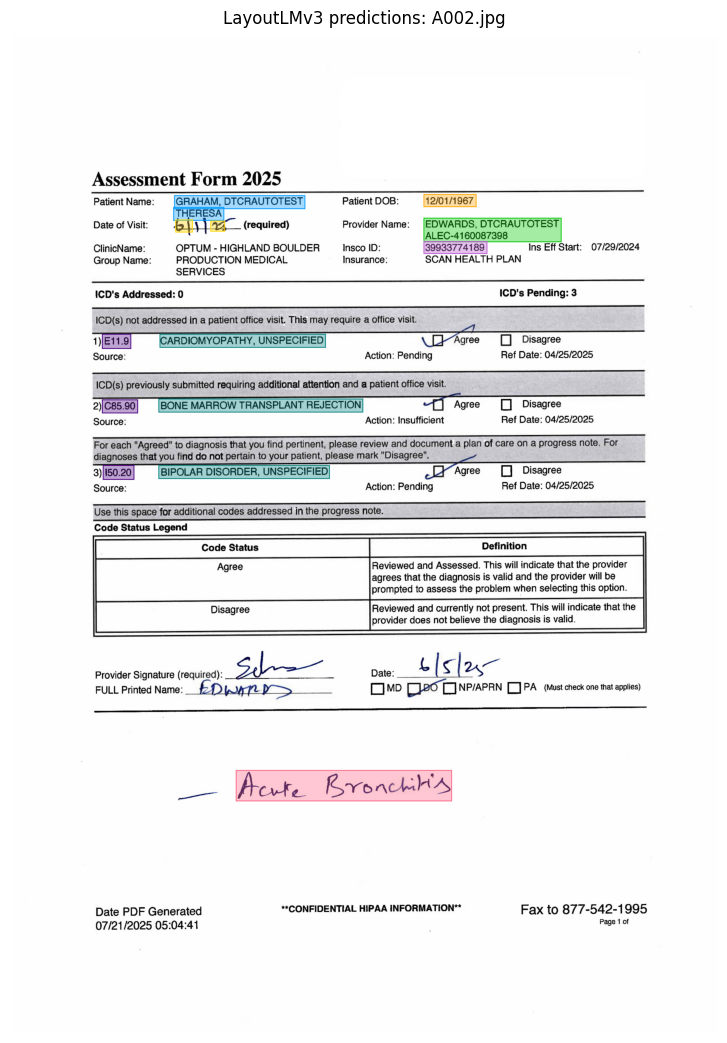


Top predicted spans per field:
 - patient_name: GRAHAM, DTCRAUTOTEST
 - patient_dob: 12/01/1967
 - visit_date: 6
 - provider_name_npi: EDWARDS, DTCRAUTOTEST ALEC-4160087398
 - insurance_id: 39933774189
 - handwritten_diagnosis: Acute Bronchihis
 - diagnosis_icd: E11.9
 - diagnosis_hcc: BONE MARROW TRANSPLANT REJECTION

Saved overlay: /content/outputs/figures/A002_layoutlm_overlay.png


In [14]:
# === Cell: Visualize LayoutLMv3 predictions on a page ===
from pathlib import Path
import json, re
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import torch
from transformers import LayoutLMv3ForTokenClassification

# ---- paths / model ----
MODEL_DIR = (OUT_DIR / "models" / "layoutlmv3_fieldtagger").resolve()
assert MODEL_DIR.exists(), f"Model dir not found: {MODEL_DIR}"
model = LayoutLMv3ForTokenClassification.from_pretrained(str(MODEL_DIR)).eval()
id2label = {int(k): v for k, v in model.config.id2label.items()} if isinstance(model.config.id2label, dict) else model.config.id2label

# ---- choose a page key (e.g., 'a001.jpg') ----
PAGE_KEY = "a002.jpg"   # <-- change this to any key in IMG_KEY2PATH
img_path = IMG_KEY2PATH[PAGE_KEY]
print("Image:", img_path)

# ---- load OCR words from cache (Cell L2) ----
OCR_DIR = REPO_DIR / "cache" / "ocr_words"
words = json.loads((OCR_DIR / f"{img_path.stem}.json").read_text())
tokens = [w["text"] for w in words]
boxes01 = [w["bbox"] for w in words]  # [x1,y1,x2,y2] normalized in [0,1]
boxes = [[max(0, min(1000, int(v*1000))) for v in b] for b in boxes01]

# ---- inference ----
enc = processor(
    images=[Image.open(img_path).convert("RGB")],
    text=[tokens],
    boxes=[boxes],
    truncation=True, padding="max_length", max_length=512, return_tensors="pt",
)
with torch.no_grad():
    out = model(
        input_ids=enc["input_ids"],
        attention_mask=enc["attention_mask"],
        bbox=enc["bbox"],
        pixel_values=enc["pixel_values"],
    )
pred_ids = out.logits.argmax(-1)[0].cpu().tolist()
word_ids = enc.word_ids(batch_index=0)

# convert token-level -> word-level labels (first subtoken label wins)
word_labels = [None]*len(tokens)
prev = None
for i_tok, wid in enumerate(word_ids):
    if wid is None:
        continue
    if wid != prev:
        word_labels[wid] = id2label[int(pred_ids[i_tok])]
        prev = wid

# ---- collect spans per field (concatenate B/I) ----
FIELDS_TO_SHOW = [
    "patient_name","patient_dob","visit_date","provider_name_npi",
    "insurance_id","handwritten_diagnosis","diagnosis_icd","diagnosis_hcc"
]
spans = {f: [] for f in FIELDS_TO_SHOW}

cur_f, cur_idxs = None, []
for idx, (tok, lab) in enumerate(zip(tokens, word_labels)):
    if lab is None or lab == "O":
        if cur_f and cur_idxs: spans[cur_f].append(cur_idxs); cur_idxs=[]
        cur_f = None
        continue
    tag, fld = lab.split("-", 1)
    if tag == "B":
        if cur_f and cur_idxs: spans[cur_f].append(cur_idxs)
        cur_f, cur_idxs = (fld if fld in spans else None), ([idx] if fld in spans else [])
    elif tag == "I":
        if cur_f == fld and cur_f in spans:
            cur_idxs.append(idx)
        else:
            if cur_f and cur_idxs: spans[cur_f].append(cur_idxs)
            cur_f = fld if fld in spans else None
            cur_idxs = [idx] if cur_f else []
if cur_f and cur_idxs: spans[cur_f].append(cur_idxs)

def detok(idxs):
    return re.sub(r"\s{2,}", " ", " ".join(tokens[i] for i in idxs)).replace(" ##","").strip()

# ---- draw overlays ----
img = Image.open(img_path).convert("RGB")
W, H = img.size
draw = ImageDraw.Draw(img, "RGBA")

palette = {
    "patient_name":       (0, 153, 255, 90),
    "patient_dob":        (255, 165, 0, 90),
    "visit_date":         (255, 215, 0, 90),
    "provider_name_npi":  (0, 200, 0, 90),
    "insurance_id":       (186, 85, 211, 90),
    "handwritten_diagnosis": (255, 99, 132, 90),
    "diagnosis_icd":      (75, 0, 130, 90),
    "diagnosis_hcc":      (0, 128, 128, 90),
}

for fld, groups in spans.items():
    color = palette.get(fld, (255,0,0,90))
    for idxs in groups:
        # union of word boxes in this span
        x1s, y1s, x2s, y2s = [], [], [], []
        for i in idxs:
            bx = boxes01[i]
            x1s.append(bx[0]*W); y1s.append(bx[1]*H)
            x2s.append(bx[2]*W); y2s.append(bx[3]*H)
        x1, y1, x2, y2 = min(x1s), min(y1s), max(x2s), max(y2s)
        draw.rectangle([x1, y1, x2, y2], outline=color[:3], width=3)
        draw.rectangle([x1, y1, x2, y2], fill=color)

# ---- show & save ----
plt.figure(figsize=(10,13))
plt.imshow(img)
plt.axis("off")
plt.title(f"LayoutLMv3 predictions: {img_path.name}")
plt.show()

# also dump top text spans per field
print("\nTop predicted spans per field:")
for fld in FIELDS_TO_SHOW:
    if not spans[fld]:
        print(f" - {fld}: (none)")
        continue
    # choose longest span by number of words
    best = max(spans[fld], key=len)
    print(f" - {fld}: {detok(best)}")

# save annotated image next to original
out_png = OUT_DIR / "figures" / f"{img_path.stem}_layoutlm_overlay.png"
out_png.parent.mkdir(parents=True, exist_ok=True)
img.save(out_png)
print("\nSaved overlay:", out_png)


Image: /content/dissertation/data/A002.jpg


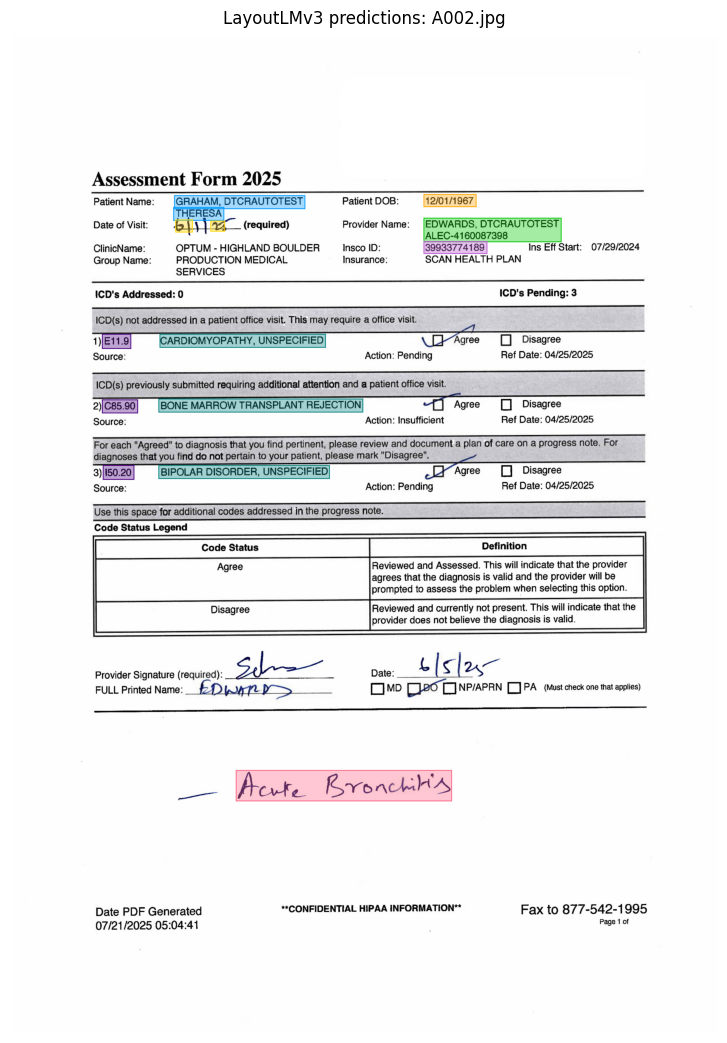


Top predicted spans per field:
 - patient_name: GRAHAM, DTCRAUTOTEST
 - patient_dob: 12/01/1967
 - visit_date: 6
 - provider_name_npi: EDWARDS, DTCRAUTOTEST ALEC-4160087398
 - insurance_id: 39933774189
 - handwritten_diagnosis: Acute Bronchihis
 - diagnosis_icd: E11.9
 - diagnosis_hcc: BONE MARROW TRANSPLANT REJECTION

Full word-label listing:
Assessment                O
Form                      O
2025                      O
Patientl                  O
Name:                     O
GRAHAM,                   B-patient_name
DTCRAUTOTEST              I-patient_name
Patient                   O
DOB:                      O
12/01/1967                B-patient_dob
THERESA                   I-patient_name
Date                      O
of                        O
Visit:                    O
6                         B-visit_date
14                        B-visit_date
(required)                O
Provider                  O
Name:                     O
EDWARDS,                  B-provider_name_npi
DT

In [15]:
# === Cell: Visualize LayoutLMv3 predictions on a page + full word-label table ===
from pathlib import Path
import json, re
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torch
from transformers import LayoutLMv3ForTokenClassification

# ---- paths / model ----
MODEL_DIR = (OUT_DIR / "models" / "layoutlmv3_fieldtagger").resolve()
assert MODEL_DIR.exists(), f"Model dir not found: {MODEL_DIR}"
model = LayoutLMv3ForTokenClassification.from_pretrained(str(MODEL_DIR)).eval()
id2label = {int(k): v for k, v in model.config.id2label.items()} if isinstance(model.config.id2label, dict) else model.config.id2label

# ---- choose a page key (e.g., 'a001.jpg') ----
PAGE_KEY = "a002.jpg"   # <-- change to your page key
img_path = IMG_KEY2PATH[PAGE_KEY]
print("Image:", img_path)

# ---- load OCR words from cache ----
OCR_DIR = REPO_DIR / "cache" / "ocr_words"
words = json.loads((OCR_DIR / f"{img_path.stem}.json").read_text())
tokens = [w["text"] for w in words]
boxes01 = [w["bbox"] for w in words]  # normalized
boxes = [[max(0, min(1000, int(v*1000))) for v in b] for b in boxes01]

# ---- inference ----
enc = processor(
    images=[Image.open(img_path).convert("RGB")],
    text=[tokens],
    boxes=[boxes],
    truncation=True, padding="max_length", max_length=512, return_tensors="pt",
)
with torch.no_grad():
    out = model(
        input_ids=enc["input_ids"],
        attention_mask=enc["attention_mask"],
        bbox=enc["bbox"],
        pixel_values=enc["pixel_values"],
    )
pred_ids = out.logits.argmax(-1)[0].cpu().tolist()
word_ids = enc.word_ids(batch_index=0)

# token → word labels
word_labels = [None]*len(tokens)
prev = None
for i_tok, wid in enumerate(word_ids):
    if wid is None:
        continue
    if wid != prev:
        word_labels[wid] = id2label[int(pred_ids[i_tok])]
        prev = wid

# ---- collect spans ----
FIELDS_TO_SHOW = [
    "patient_name","patient_dob","visit_date","provider_name_npi",
    "insurance_id","handwritten_diagnosis","diagnosis_icd","diagnosis_hcc"
]
spans = {f: [] for f in FIELDS_TO_SHOW}

cur_f, cur_idxs = None, []
for idx, (tok, lab) in enumerate(zip(tokens, word_labels)):
    if lab is None or lab == "O":
        if cur_f and cur_idxs: spans[cur_f].append(cur_idxs); cur_idxs=[]
        cur_f = None
        continue
    tag, fld = lab.split("-", 1)
    if tag == "B":
        if cur_f and cur_idxs: spans[cur_f].append(cur_idxs)
        cur_f, cur_idxs = (fld if fld in spans else None), ([idx] if fld in spans else [])
    elif tag == "I":
        if cur_f == fld and cur_f in spans:
            cur_idxs.append(idx)
        else:
            if cur_f and cur_idxs: spans[cur_f].append(cur_idxs)
            cur_f = fld if fld in spans else None
            cur_idxs = [idx] if cur_f else []
if cur_f and cur_idxs: spans[cur_f].append(cur_idxs)

def detok(idxs):
    return re.sub(r"\s{2,}", " ", " ".join(tokens[i] for i in idxs)).replace(" ##","").strip()

# ---- draw overlays ----
img = Image.open(img_path).convert("RGB")
W, H = img.size
draw = ImageDraw.Draw(img, "RGBA")

palette = {
    "patient_name":       (0, 153, 255, 90),
    "patient_dob":        (255, 165, 0, 90),
    "visit_date":         (255, 215, 0, 90),
    "provider_name_npi":  (0, 200, 0, 90),
    "insurance_id":       (186, 85, 211, 90),
    "handwritten_diagnosis": (255, 99, 132, 90),
    "diagnosis_icd":      (75, 0, 130, 90),
    "diagnosis_hcc":      (0, 128, 128, 90),
}

for fld, groups in spans.items():
    color = palette.get(fld, (255,0,0,90))
    for idxs in groups:
        x1s, y1s, x2s, y2s = [], [], [], []
        for i in idxs:
            bx = boxes01[i]
            x1s.append(bx[0]*W); y1s.append(bx[1]*H)
            x2s.append(bx[2]*W); y2s.append(bx[3]*H)
        x1, y1, x2, y2 = min(x1s), min(y1s), max(x2s), max(y2s)
        draw.rectangle([x1, y1, x2, y2], outline=color[:3], width=3)
        draw.rectangle([x1, y1, x2, y2], fill=color)

# ---- show overlay ----
plt.figure(figsize=(10,13))
plt.imshow(img)
plt.axis("off")
plt.title(f"LayoutLMv3 predictions: {img_path.name}")
plt.show()

# ---- Top predicted spans per field ----
print("\nTop predicted spans per field:")
for fld in FIELDS_TO_SHOW:
    if not spans[fld]:
        print(f" - {fld}: (none)")
        continue
    best = max(spans[fld], key=len)
    print(f" - {fld}: {detok(best)}")

# ---- FULL WORD-LABEL TABLE ----
print("\nFull word-label listing:")
for tok, lab in zip(tokens, word_labels):
    print(f"{tok:<25} {lab if lab else 'O'}")

# ---- Save annotated image ----
out_png = OUT_DIR / "figures" / f"{img_path.stem}_layoutlm_overlay.png"
out_png.parent.mkdir(parents=True, exist_ok=True)
img.save(out_png)
print("\nSaved overlay:", out_png)


Checkboxes Detector OPEN CV ..not working

In [16]:
# === Cell L6 (updated): checkbox scoring + calibration, store per-box scores ===
import cv2, numpy as np
from pathlib import Path
from PIL import Image

assert 'REGIONS' in globals() and 'CHECKBOX_GT' in globals(), "Run Cell L3 first."
assert 'IMG_KEY2PATH' in globals() and 'OUT_DIR' in globals(), "Run Cell L4 first."

DBG_DIR = OUT_DIR / "figures" / "checkbox_debug"
DBG_DIR.mkdir(parents=True, exist_ok=True)

def load_rgb(path: Path) -> np.ndarray:
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

def crop_norm(img: np.ndarray, box01, pad=0.08) -> np.ndarray:
    h, w = img.shape[:2]
    x1,y1,x2,y2 = box01
    dx, dy = (x2-x1)*pad, (y2-y1)*pad
    x1 = max(0, int((x1 - dx) * w)); y1 = max(0, int((y1 - dy) * h))
    x2 = min(w, int((x2 + dx) * w)); y2 = min(h, int((y2 + dy) * h))
    if x2 <= x1 or y2 <= y1:
        return img[0:1, 0:1].copy()
    return img[y1:y2, x1:x2].copy()

def preprocess(gray: np.ndarray) -> np.ndarray:
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    g = clahe.apply(gray)
    return cv2.GaussianBlur(g, (3,3), 0)

def binarize(gray: np.ndarray):
    _, th_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    b_otsu = (th_otsu > 0).astype(np.uint8)
    th_ad = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                  cv2.THRESH_BINARY_INV, 11, 2)
    b_ad = (th_ad > 0).astype(np.uint8)
    return b_otsu, b_ad

def inner_mask(shape, margin=0.18):
    h, w = shape[:2]
    y1 = int(h*margin); y2 = int(h*(1-margin))
    x1 = int(w*margin); x2 = int(w*(1-margin))
    m = np.zeros((h,w), dtype=np.uint8)
    if y2>y1 and x2>x1: m[y1:y2, x1:x2] = 1
    return m

def edge_density(gray_inner: np.ndarray) -> float:
    sx = cv2.Sobel(gray_inner, cv2.CV_32F, 1, 0, ksize=3)
    sy = cv2.Sobel(gray_inner, cv2.CV_32F, 0, 1, ksize=3)
    mag = cv2.magnitude(sx, sy)
    return float(np.clip(float(np.mean(mag)) / 50.0, 0.0, 1.0))

def checkbox_score(crop_rgb: np.ndarray) -> float:
    gray = cv2.cvtColor(crop_rgb, cv2.COLOR_RGB2GRAY)
    gray = preprocess(gray)
    b1, b2 = binarize(gray)
    mask = inner_mask(gray.shape, margin=0.18)
    ink = 0.5 * ((b1 * mask).sum() + (b2 * mask).sum()) / (mask.sum() + 1e-6)
    gy = gray.copy(); gy[mask == 0] = 255
    edg = edge_density(gy)
    return float(0.6 * ink + 0.4 * edg)

# ---- Calibrate one global threshold from CHECKBOX_GT ----
def calibrate_threshold():
    y_true, y_score = [], []
    for key, items in CHECKBOX_GT.items():
        img = load_rgb(IMG_KEY2PATH[key])
        for it in items:
            s = checkbox_score(crop_norm(img, it["bbox"], pad=0.06))
            y_score.append(s)
            y_true.append(1 if it["state"] == "checked" else 0)
    if not y_true:
        return 0.40, {"f1":0,"precision":0,"recall":0,"n":0}
    best_t, best_f1, best_pr, best_rc = 0.5, -1, 0, 0
    for t in np.linspace(0.15, 0.85, 71):
        tp=fp=fn=0
        for yt, ys in zip(y_true, y_score):
            yp = 1 if ys >= t else 0
            if yp==1 and yt==1: tp+=1
            elif yp==1 and yt==0: fp+=1
            elif yp==0 and yt==1: fn+=1
        prec = tp / (tp+fp+1e-9); rec = tp / (tp+fn+1e-9)
        f1 = 2*prec*rec/(prec+rec+1e-9)
        if f1 > best_f1:
            best_f1, best_t, best_pr, best_rc = f1, float(t), prec, rec
    return best_t, {"f1":best_f1, "precision":best_pr, "recall":best_rc, "n":len(y_true)}

THRESH, calib_stats = calibrate_threshold()
print(f"Calibrated threshold: {THRESH:.3f}  (F1={calib_stats['f1']:.3f}, "
      f"P={calib_stats['precision']:.3f}, R={calib_stats['recall']:.3f}, N={calib_stats['n']})")

# ---- Score & store all LS checkbox boxes (keep kind, bbox, score) ----
CHECKBOX_SCORES = {}  # key -> {'agree':[...], 'disagree':[...]} with score
for key, labs in REGIONS.items():
    img = load_rgb(IMG_KEY2PATH[key])
    page = {"agree": [], "disagree": []}
    for kind in ("checkbox_agree", "checkbox_disagree"):
        for bb in labs.get(kind, []):
            s = checkbox_score(crop_norm(img, bb, pad=0.06))
            page["agree" if kind.endswith("agree") else "disagree"].append({"bbox": bb, "score": s})
    CHECKBOX_SCORES[key] = page
print("Scored checkboxes for", len(CHECKBOX_SCORES), "pages.")


Calibrated threshold: 0.590  (F1=0.810, P=0.782, R=0.839, N=557)
Scored checkboxes for 74 pages.


In [17]:
# === Cell L7a (updated): ICD/HCC rows + per-row Agree/Disagree decision ===
import json, re
from pathlib import Path

assert 'REGIONS' in globals() and 'CHECKBOX_SCORES' in globals() and 'THRESH' in globals()
assert 'IMG_KEY2PATH' in globals() and 'REPO_DIR' in globals()

JSON_DIR = OUT_DIR / "json"
JSON_DIR.mkdir(parents=True, exist_ok=True)

def v_overlap_ratio(a, b):
    ay1, ay2 = a[1], a[3]; by1, by2 = b[1], b[3]
    inter = max(0.0, min(ay2, by2) - max(ay1, by1))
    minh = max(1e-9, min(ay2 - ay1, by2 - by1))
    return inter / minh

def h_center(b): return 0.5*(b[0]+b[2])

OCR_DIR = REPO_DIR / "cache" / "ocr_words"
def load_ocr_words(img_path: Path):
    return json.loads((OCR_DIR / f"{img_path.stem}.json").read_text())

def words_in_region(words, reg01, min_iou=0.05):
    rx1, ry1, rx2, ry2 = reg01
    r1000 = [int(rx1*1000), int(ry1*1000), int(rx2*1000), int(ry2*1000)]
    out = []
    for w in words:
        x1,y1,x2,y2 = [int(t*1000) for t in w["bbox"]]
        ix1, iy1 = max(x1, r1000[0]), max(y1, r1000[1])
        ix2, iy2 = min(x2, r1000[2]), min(y2, r1000[3])
        iw, ih = max(0, ix2-ix1), max(0, iy2-iy1)
        inter = iw*ih
        if inter == 0:
            continue
        aw = max(1, x2-x1); ah = max(1, y2-y1)
        bw = max(1, r1000[2]-r1000[0]); bh = max(1, r1000[3]-r1000[1])
        iou = inter / (aw*ah + bw*bh - inter)
        if iou >= min_iou:
            out.append(w)
    out.sort(key=lambda w: (w["bbox"][1], w["bbox"][0]))
    return out

def join_words(words):
    txt = " ".join(w["text"] for w in words)
    return re.sub(r"\s{2,}", " ", txt).strip()

# --- row builder with per-row checkbox resolution ---
def build_rows_for_page(img_key, tie_margin=0.06, min_v_overlap=0.25):
    labs = REGIONS.get(img_key, {})
    img_path = IMG_KEY2PATH[img_key]
    words = load_ocr_words(img_path)

    icd_boxes = labs.get("diagnosis_icd", [])
    hcc_boxes = labs.get("diagnosis_hcc", [])
    # index rows top->bottom by ICD y
    row_idx = sorted(range(len(icd_boxes)), key=lambda i: icd_boxes[i][1])

    # text extraction
    rows = []
    for i in row_idx:
        icd_box = icd_boxes[i]
        # pick HCC with max vertical overlap
        best_j, best_ov = None, 0.0
        for j, hb in enumerate(hcc_boxes):
            ov = v_overlap_ratio(icd_box, hb)
            if ov > best_ov: best_ov, best_j = ov, j
        hcc_box = hcc_boxes[best_j] if best_j is not None else icd_box
        rows.append({
            "icd_box": icd_box,
            "hcc_box": hcc_box,
            "icd": join_words(words_in_region(words, icd_box, min_iou=0.05)),
            "hcc_description": join_words(words_in_region(words, hcc_box, min_iou=0.05)),
            # will set agree/disagree/not_attested below
            "agree": False, "disagree": False, "not_attested": False,
            # debug
            "_scores": {}
        })

    # attach checkbox scores per row (choose best overlapping agree & disagree)
    page_scores = CHECKBOX_SCORES.get(img_key, {"agree":[], "disagree":[]})
    for r in rows:
        # best agree
        best_ag, sc_ag = None, -1.0
        for cb in page_scores["agree"]:
            ov = v_overlap_ratio(cb["bbox"], r["hcc_box"])
            if ov < min_v_overlap:
                continue
            # prefer closer horizontally (smaller abs center distance)
            score = ov / (abs(h_center(cb["bbox"]) - h_center(r["hcc_box"])) + 1e-6)
            if score > sc_ag:
                sc_ag, best_ag = score, cb
        # best disagree
        best_di, sc_di = None, -1.0
        for cb in page_scores["disagree"]:
            ov = v_overlap_ratio(cb["bbox"], r["hcc_box"])
            if ov < min_v_overlap:
                continue
            score = ov / (abs(h_center(cb["bbox"]) - h_center(r["hcc_box"])) + 1e-6)
            if score > sc_di:
                sc_di, best_di = score, cb

        s_ag = best_ag["score"] if best_ag else 0.0
        s_di = best_di["score"] if best_di else 0.0
        r["_scores"] = {"agree": s_ag, "disagree": s_di}

        # --- decide flags (winner-takes-all with tie guard) ---
        # nothing confidently checked
        if max(s_ag, s_di) < THRESH:
            r["not_attested"] = True
        else:
            # both confident -> compare with margin
            if s_ag >= THRESH and s_di >= THRESH:
                if s_ag >= s_di + tie_margin:
                    r["agree"] = True
                elif s_di >= s_ag + tie_margin:
                    r["disagree"] = True
                else:
                    # near tie -> pick higher but mark as not_attested for safety
                    if s_ag >= s_di:
                        r["agree"] = True
                    else:
                        r["disagree"] = True
            elif s_ag >= THRESH:
                r["agree"] = True
            elif s_di >= THRESH:
                r["disagree"] = True

            if not r["agree"] and not r["disagree"]:
                r["not_attested"] = True

    return rows

# quick smoke on A001
_first = next(iter(sorted(IMG_KEY2PATH.keys())))
rows = build_rows_for_page(_first)
print(f"{_first}: built {len(rows)} rows. First two with scores:")
print(json.dumps([{k:v for k,v in r.items() if k!='icd_box' and k!='hcc_box'} for r in rows[:6]], indent=2))


a001.jpg: built 4 rows. First two with scores:
[
  {
    "icd": "E11.51",
    "hcc_description": "DISEASES CLASSIFIED WITHOUT BEHAVIORAL ELSEWHERE, PSYCHOTIC DISTURBANCE, DISTURBANCE, DISTURBANCE,",
    "agree": true,
    "disagree": false,
    "not_attested": false,
    "_scores": {
      "agree": 0.6658605972504548,
      "disagree": 0.0
    }
  },
  {
    "icd": "G40.409",
    "hcc_description": "DIABETES MELLITUS PROLIFERATIVE DIABETIC RETINOPATHY WITHOUT EDEMA, MACULAR UNSPECIFIED",
    "agree": true,
    "disagree": false,
    "not_attested": false,
    "_scores": {
      "agree": 0.5977130975760824,
      "disagree": 0.0
    }
  },
  {
    "icd": "170.25",
    "hcc_description": "EPILEPSY EPILEPTIC OTHER GENERALIZED WITHOUT STATUS INTRACTABLE, SYNDROMES, EPILEPTICUS",
    "agree": false,
    "disagree": false,
    "not_attested": true,
    "_scores": {
      "agree": 0.5704954953674959,
      "disagree": 0.0
    }
  },
  {
    "icd": "E11.59",
    "hcc_description": "DISEASE, CH

Trying YOLOv8 detector

In [18]:
# === Cell L6.yolo: Build YOLO dataset for checked checkboxes (2 classes) ===
import os, json, shutil, random
from pathlib import Path

# Prereqs from earlier cells:
# - REGIONS, CHECKBOX_GT, IMG_KEY2PATH (Cell L3 final + L4 final)
# - OUT_DIR, REPO_DIR

random.seed(42)

YOLO_DIR = OUT_DIR / "yolo_chk"
IM_TRAIN = YOLO_DIR / "images" / "train"
IM_VAL   = YOLO_DIR / "images" / "val"
LB_TRAIN = YOLO_DIR / "labels" / "train"
LB_VAL   = YOLO_DIR / "labels" / "val"
for d in [IM_TRAIN, IM_VAL, LB_TRAIN, LB_VAL]:
    d.mkdir(parents=True, exist_ok=True)

# Split keys 80/20, deterministic
all_keys = sorted(IMG_KEY2PATH.keys())
cut = int(0.8 * len(all_keys))
train_keys, val_keys = all_keys[:cut], all_keys[cut:]
split_of = {k: "train" for k in train_keys}
split_of.update({k: "val" for k in val_keys})

# Helper: write YOLO txt for one image
# YOLO box format: class cx cy w h (all in [0,1])
def xyxy01_to_xywh01(b):
    x1,y1,x2,y2 = b
    cx = (x1+x2)/2.0; cy=(y1+y2)/2.0; w=(x2-x1); h=(y2-y1)
    return cx, cy, max(1e-6, w), max(1e-6, h)

CLS_MAP = {"agree_checked": 0, "disagree_checked": 1}

# Build labels from LS "Checked" states only
n_pos, n_imgs = 0, 0
for key, path in IMG_KEY2PATH.items():
    split = split_of[key]
    im_dst = (IM_TRAIN if split=="train" else IM_VAL) / path.name
    # Copy images (fast enough; you can symlink if preferred)
    shutil.copy2(path, im_dst)
    n_imgs += 1

    # Create label file
    lb_dst = (LB_TRAIN if split=="train" else LB_VAL) / (path.stem + ".txt")
    lines = []
    # Use CHECKBOX_GT (has states + kind). If missing (shouldn't), fallback to regions none.
    for it in CHECKBOX_GT.get(key, []):
        if it["state"] != "checked":   # only positives to learn "checked" marks
            continue
        kind = it["kind"]            # "agree" or "disagree"
        cls = CLS_MAP["agree_checked" if kind=="agree" else "disagree_checked"]
        cx, cy, w, h = xyxy01_to_xywh01(it["bbox"])
        lines.append(f"{cls} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}")

    # Write (empty file is OK → negative sample)
    lb_dst.write_text("\n".join(lines))

print(f"YOLO dataset ready at {YOLO_DIR}")
print(f" Train images: {len(train_keys)}, Val images: {len(val_keys)}, Positives: ~{sum(1 for k in CHECKBOX_GT for i in CHECKBOX_GT[k] if i['state']=='checked')}")
# Write data.yaml
(YOLO_DIR / "data.yaml").write_text(
f"""path: {YOLO_DIR.as_posix()}
train: images/train
val: images/val
names:
  0: agree_checked
  1: disagree_checked
"""
)
print("Wrote:", YOLO_DIR / "data.yaml")


YOLO dataset ready at /content/outputs/yolo_chk
 Train images: 59, Val images: 15, Positives: ~274
Wrote: /content/outputs/yolo_chk/data.yaml


In [19]:
# === Cell L7.yolo_train (fixed print) ===
import os, sys, subprocess, importlib
def pip_quiet(pkgs): subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

# (Optional) really turn off wandb logging
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"

try:
    import ultralytics
except Exception:
    pip_quiet(["ultralytics>=8.1.0,<8.3.0"])
    importlib.invalidate_caches()
    import ultralytics

from ultralytics import YOLO

YOLO_DIR = OUT_DIR / "yolo_chk"
assert (YOLO_DIR / "data.yaml").exists(), "Run Cell L6.yolo first"

# Tidy runs dir
try:
    ultralytics.settings.update({"runs_dir": str((YOLO_DIR / "runs").resolve())})
except Exception:
    pass

model = YOLO("yolov8n.pt")

print("Starting YOLO training…")
_ = model.train(
    data=str((YOLO_DIR / "data.yaml").resolve()),
    epochs=60,
    imgsz=640,
    batch=8,
    lr0=0.01,
    patience=30,
    project="chk_runs",   # project name, not a path
    name="v8n",
    optimizer="SGD",
    verbose=False,
    device=0 if ultralytics.utils.checks.cuda_device_count() > 0 else "cpu",
)

# <<< this is the reliable way to get the file >>>
best_path = Path(model.trainer.best).resolve()
save_dir  = Path(model.trainer.save_dir).resolve()
print("Best weights:", best_path)
print("Run dir:", save_dir)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 139MB/s]


Starting YOLO training…
New https://pypi.org/project/ultralytics/8.3.179 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.103 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/outputs/yolo_chk/data.yaml, epochs=60, time=None, patience=30, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=chk_runs, name=v8n, exist_ok=False, pretrained=True, optimizer=SGD, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False,

100%|██████████| 755k/755k [00:00<00:00, 36.8MB/s]

Overriding model.yaml nc=80 with nc=2



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:254: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:259: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this o

AMP: checks passed ✅


train: Scanning /content/outputs/yolo_chk/labels/train... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<00:00, 1959.26it/s]

train: New cache created: /content/outputs/yolo_chk/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/ultralytics/data/augment.py:1837: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/outputs/yolo_chk/labels/val... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<00:00, 680.09it/s]

val: New cache created: /content/outputs/yolo_chk/labels/val.cache


Plotting labels to chk_runs/v8n/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to chk_runs/v8n
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       1/60      5.01G      4.242      17.66      1.398         24        640: 100%|██████████| 8/8 [00:03<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       2/60      2.63G      3.829      12.93      1.296         17        640: 100%|██████████| 8/8 [00:01<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       3/60      2.67G      3.419      8.523      1.121         17        640: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       4/60      2.66G      2.913      6.529     0.9678         26        640: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       5/60      2.68G      2.733      5.959     0.8957         16        640: 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58   0.000171     0.0125   8.83e-05   1.77e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       6/60      2.67G      3.231      5.714     0.9651         16        640: 100%|██████████| 8/8 [00:01<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58   0.000329      0.025   0.000175   5.24e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       7/60      2.68G      3.254      5.178     0.9324          7        640: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58    0.00283      0.215    0.00259    0.00083



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       8/60      2.72G      3.134      4.731     0.9405         26        640: 100%|██████████| 8/8 [00:01<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58    0.00768      0.594     0.0115    0.00305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       9/60      2.66G      3.249      4.326     0.9845         21        640: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58     0.0099      0.786      0.148     0.0268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      10/60      2.72G      3.207      4.241     0.9745         10        640: 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58    0.00933      0.733     0.0597    0.00783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      11/60      2.69G      3.296      3.954     0.9723         16        640: 100%|██████████| 8/8 [00:01<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.753      0.312      0.333     0.0614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      12/60      2.68G      3.364      4.187     0.9527         23        640: 100%|██████████| 8/8 [00:01<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58     0.0772      0.113     0.0514     0.0104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      13/60      2.67G      3.385       3.91     0.9662         29        640: 100%|██████████| 8/8 [00:01<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.318      0.219      0.316     0.0563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      14/60      2.68G      3.413      4.012      0.967         13        640: 100%|██████████| 8/8 [00:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.107      0.225      0.168      0.024



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      15/60      2.68G      3.113      3.959     0.9629         11        640: 100%|██████████| 8/8 [00:01<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.011      0.867      0.531      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      16/60      2.67G      2.967      3.604     0.8856         23        640: 100%|██████████| 8/8 [00:01<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.436      0.533      0.595      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      17/60      2.67G      3.222      3.615     0.9662         23        640: 100%|██████████| 8/8 [00:01<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.198      0.436      0.218     0.0515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      18/60      2.68G      2.949      3.301     0.9434          9        640: 100%|██████████| 8/8 [00:01<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.356       0.61      0.426      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      19/60      2.68G      2.836      3.105     0.8848         36        640: 100%|██████████| 8/8 [00:01<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.417      0.632      0.502      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      20/60      2.68G      2.907      3.122     0.9054         10        640: 100%|██████████| 8/8 [00:01<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.363      0.551       0.43      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      21/60      2.67G      2.861      2.979     0.8781         29        640: 100%|██████████| 8/8 [00:01<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.495      0.561      0.501      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      22/60      2.68G      2.486      2.768     0.8867         20        640: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.438      0.688      0.607       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      23/60      2.67G      2.748      2.595     0.9034         30        640: 100%|██████████| 8/8 [00:01<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58       0.46      0.454      0.426     0.0925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      24/60      2.68G      2.624      2.379      0.894         20        640: 100%|██████████| 8/8 [00:01<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.578      0.502      0.617      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      25/60      2.67G      2.662      2.546     0.8957         18        640: 100%|██████████| 8/8 [00:01<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.659      0.567      0.604      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      26/60      2.68G      2.611      2.635     0.8881          8        640: 100%|██████████| 8/8 [00:01<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.549      0.636      0.628      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      27/60      2.68G      2.673      2.515     0.8853         24        640: 100%|██████████| 8/8 [00:01<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.577      0.728      0.674      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      28/60      2.67G       2.59      2.499     0.8946         19        640: 100%|██████████| 8/8 [00:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.574      0.662      0.662       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      29/60      2.68G       2.61      2.553     0.8796         14        640: 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.599      0.642      0.685      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      30/60      2.67G       2.49      2.314     0.8866         25        640: 100%|██████████| 8/8 [00:01<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.674      0.639        0.7      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      31/60      2.68G      2.364      2.373     0.8765          8        640: 100%|██████████| 8/8 [00:01<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.753      0.764      0.791      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      32/60      2.69G      2.176      2.258      0.882         11        640: 100%|██████████| 8/8 [00:01<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.695      0.831      0.775      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      33/60      2.68G      2.339       2.31     0.8723         16        640: 100%|██████████| 8/8 [00:01<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.883      0.782      0.884      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      34/60      2.68G        2.3      2.051     0.8685          9        640: 100%|██████████| 8/8 [00:01<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58       0.75       0.84      0.787      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      35/60      2.68G      2.234      2.124     0.8807         11        640: 100%|██████████| 8/8 [00:01<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.841      0.789      0.868      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      36/60      2.69G      2.087      2.004     0.8548         10        640: 100%|██████████| 8/8 [00:01<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.854      0.932      0.942      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      37/60      2.68G      2.332      2.201     0.8612          9        640: 100%|██████████| 8/8 [00:01<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58       0.83      0.792      0.828      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      38/60      2.68G      2.143      1.887     0.8535         11        640: 100%|██████████| 8/8 [00:01<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.907      0.905      0.948      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      39/60      2.67G       2.26      1.957     0.8641         17        640: 100%|██████████| 8/8 [00:01<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58       0.79      0.849      0.826      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      40/60      2.68G      2.135      2.154     0.8419          3        640: 100%|██████████| 8/8 [00:01<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58       0.92      0.918      0.974       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      41/60      2.68G      2.053      1.637     0.8636         12        640: 100%|██████████| 8/8 [00:01<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.839      0.853      0.872      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      42/60      2.68G      2.318      1.848     0.8838         12        640: 100%|██████████| 8/8 [00:01<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.931      0.937      0.983      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      43/60      2.68G      2.073      1.688     0.8514         18        640: 100%|██████████| 8/8 [00:01<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.902      0.917      0.952      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      44/60       2.7G      2.088      1.678     0.8269         22        640: 100%|██████████| 8/8 [00:01<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.944      0.929      0.965      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      45/60      2.67G      2.246      1.763     0.8505         20        640: 100%|██████████| 8/8 [00:01<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.864      0.935      0.922      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      46/60      2.68G      2.071      1.759     0.8421          7        640: 100%|██████████| 8/8 [00:01<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.932      0.984       0.99      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      47/60      2.69G      2.026      1.725     0.8446         19        640: 100%|██████████| 8/8 [00:01<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58       0.98      0.875      0.959      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      48/60      2.68G      2.024      1.717     0.8636         10        640: 100%|██████████| 8/8 [00:01<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.928      0.988      0.992      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      49/60      2.67G      1.975      1.582     0.8139         30        640: 100%|██████████| 8/8 [00:01<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.945      0.939      0.963      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      50/60      2.68G      2.183      1.795      0.838         12        640: 100%|██████████| 8/8 [00:01<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.953      0.985      0.993      0.459


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/ultralytics/data/augment.py:1837: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      51/60      2.68G      1.969      1.745     0.8529         14        640: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.956      0.975       0.99      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      52/60      2.67G      2.015      1.681     0.8492         11        640: 100%|██████████| 8/8 [00:02<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.948      0.981      0.991      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      53/60      2.68G      2.035      1.845     0.8494         14        640: 100%|██████████| 8/8 [00:01<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.995          1      0.995      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      54/60      2.67G      2.128      1.862     0.8545         11        640: 100%|██████████| 8/8 [00:01<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.971      0.987      0.995      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      55/60      2.68G      2.016      1.598     0.8725         12        640: 100%|██████████| 8/8 [00:01<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58       0.97      0.983      0.995      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      56/60      2.67G      1.936      1.728      0.857          9        640: 100%|██████████| 8/8 [00:01<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.968      0.985      0.995      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      57/60      2.67G      1.902       1.62     0.8481         10        640: 100%|██████████| 8/8 [00:01<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.976      0.993      0.995      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      58/60      2.68G      1.934      1.603     0.8256         10        640: 100%|██████████| 8/8 [00:01<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.987      0.991      0.995      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      59/60      2.67G      1.956      1.547     0.8595          9        640: 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58      0.989      0.992      0.995      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      60/60      2.68G      1.884      1.573     0.8353         12        640: 100%|██████████| 8/8 [00:01<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R   

                   all         15         58       0.99      0.995      0.995      0.445



60 epochs completed in 0.053 hours.
Optimizer stripped from chk_runs/v8n/weights/last.pt, 6.2MB
Optimizer stripped from chk_runs/v8n/weights/best.pt, 6.2MB

Validating chk_runs/v8n/weights/best.pt...
Ultralytics YOLOv8.2.103 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:254: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:259: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this o

                   all         15         58      0.953      0.986      0.993       0.46
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to chk_runs/v8n
Best weights: /content/chk_runs/v8n/weights/best.pt
Run dir: /content/chk_runs/v8n


In [20]:
# === Cell L7a.yolo_eval: quick validation metrics + plots ===
# Evaluate the trained detector on the val split and save plots
from pathlib import Path
from ultralytics import YOLO
import ultralytics

YOLO_DIR = OUT_DIR / "yolo_chk"
runs_dir = (YOLO_DIR / "runs").resolve()

# Find the latest run under project 'chk_runs'
# (works even if you trained multiple times)
candidates = sorted(Path("chk_runs").glob("*/weights/best.pt")) + \
             sorted(runs_dir.glob("*/weights/best.pt"))
assert candidates, "No best.pt found. Train in L7 first."
BEST = candidates[-1]
print("Evaluating:", BEST)

model = YOLO(str(BEST))
metrics = model.val(
    data=str((YOLO_DIR / "data.yaml").resolve()),
    split="val",
    imgsz=640,
    plots=True,           # PR curves, confusion matrix, F1 curve, etc.
    save_hybrid=False
)
print("mAP50:", metrics.box.map50, "mAP50-95:", metrics.box.map)
print("Precision:", metrics.box.mp, "Recall:", metrics.box.mr)
print("Plots saved under:", Path(metrics.save_dir).resolve())


Evaluating: chk_runs/v8n/weights/best.pt
Ultralytics YOLOv8.2.103 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:254: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:259: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this o

Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/outputs/yolo_chk/labels/val.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.22s/it]


                   all         15         58      0.953      0.986      0.993      0.457
         agree_checked         15         40      0.975      0.972      0.994      0.526
      disagree_checked         12         18      0.932          1      0.992      0.387
Speed: 0.2ms preprocess, 35.0ms inference, 0.0ms loss, 7.7ms postprocess per image
Results saved to runs/detect/val
mAP50: 0.9930744544287547 mAP50-95: 0.4566153754080437
Precision: 0.953299961861226 Recall: 0.9858376265265066
Plots saved under: /content/runs/detect/val


In [21]:
# === Cell L7b.yolo_infer: predict checkmarks on any image ===
# Detect checked Agree/Disagree boxes on a page and return normalized results
import numpy as np
from pathlib import Path
from ultralytics import YOLO

def resolve_best_yolo():
    # prefer the latest under project dir
    candidates = sorted(Path("chk_runs").glob("*/weights/best.pt"))
    if not candidates:
        # fallback to dataset runs folder
        candidates = sorted((OUT_DIR / "yolo_chk" / "runs").glob("*/weights/best.pt"))
    if not candidates:
        raise FileNotFoundError("No YOLO best.pt found. Train in L7.")
    return candidates[-1]

BEST = resolve_best_yolo()
print("Using YOLO weights:", BEST)
yolo = YOLO(str(BEST))

CLASS_NAMES = {0: "agree_checked", 1: "disagree_checked"}

def detect_checked_boxes(img_path: Path, conf=0.35):
    """
    Return: {'agree': [{'bbox':[x1,y1,x2,y2], 'score':0.92}, ...],
             'disagree': [...]}
    bbox normalized to [0,1].
    """
    res = yolo.predict(source=str(img_path), imgsz=640, conf=conf, verbose=False)[0]
    out = {"agree": [], "disagree": []}
    if res.boxes is None or len(res.boxes) == 0:
        return out
    imw, imh = res.orig_shape[1], res.orig_shape[0]
    for b, c, s in zip(res.boxes.xyxy.cpu().numpy(),
                       res.boxes.cls.cpu().numpy().astype(int),
                       res.boxes.conf.cpu().numpy()):
        x1, y1, x2, y2 = b.tolist()
        bb01 = [x1/imw, y1/imh, x2/imw, y2/imh]
        if c == 0:
            out["agree"].append({"bbox": bb01, "score": float(s)})
        elif c == 1:
            out["disagree"].append({"bbox": bb01, "score": float(s)})
    return out

# Example:
img_key = "a001.jpg"
preds = detect_checked_boxes(IMG_KEY2PATH[img_key], conf=0.35)
preds


Using YOLO weights: chk_runs/v8n/weights/best.pt


/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:254: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:259: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this o

{'agree': [{'bbox': [0.5899114028334089,
    0.3605192743770483,
    0.613048130636588,
    0.37640873106431677],
   'score': 0.5457176566123962},
  {'bbox': [0.587995425389208,
    0.28682274110434774,
    0.6118696920816958,
    0.30284962690804],
   'score': 0.48911625146865845}],
 'disagree': [{'bbox': [0.6889194794500705,
    0.45044992424613495,
    0.7105832943653013,
    0.4658498821111784],
   'score': 0.8610398173332214},
  {'bbox': [0.6915119852283605,
    0.5120812386452693,
    0.711565416698156,
    0.5270941476938764],
   'score': 0.5577747225761414}]}

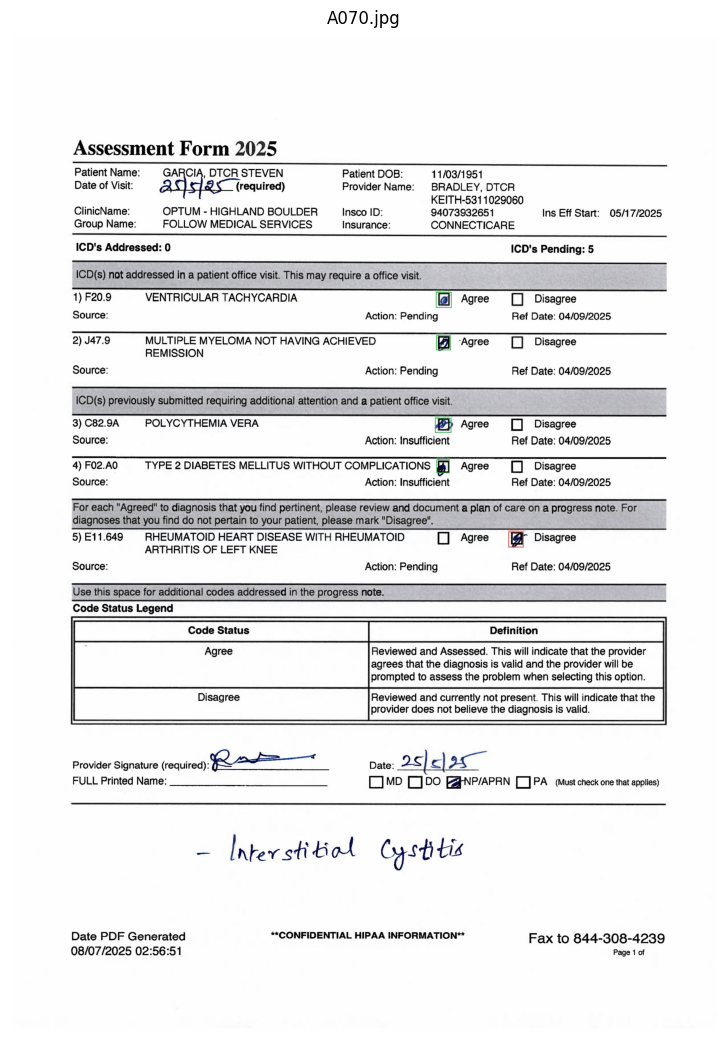

Saved: /content/outputs/figures/A070_yolo_chk.png


In [22]:
# === Cell L7c.yolo_vis: draw detections for a quick sanity check ===
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

def draw_yolo_checks(img_path: Path, preds: dict, save=True):
    img = Image.open(img_path).convert("RGB")
    W, H = img.size
    draw = ImageDraw.Draw(img)
    def to_px(b): return [b[0]*W, b[1]*H, b[2]*W, b[3]*H]

    for it in preds.get("agree", []):
        draw.rectangle(to_px(it["bbox"]), outline=(66, 180, 86), width=3)
        draw.text((to_px(it["bbox"])[0], to_px(it["bbox"])[1]-12),
                  f"agree {it['score']:.2f}", fill=(66,180,86))
    for it in preds.get("disagree", []):
        draw.rectangle(to_px(it["bbox"]), outline=(220, 80, 70), width=3)
        draw.text((to_px(it["bbox"])[0], to_px(it["bbox"])[1]-12),
                  f"disagree {it['score']:.2f}", fill=(220,80,70))

    plt.figure(figsize=(10,13)); plt.imshow(img); plt.axis("off")
    plt.title(img_path.name); plt.show()
    if save:
        out = OUT_DIR / "figures" / f"{img_path.stem}_yolo_chk.png"
        out.parent.mkdir(parents=True, exist_ok=True)
        img.save(out); print("Saved:", out)

# Example:
k = "a070.jpg"; p = IMG_KEY2PATH[k]
preds = detect_checked_boxes(p, conf=0.20)
draw_yolo_checks(p, preds)


In [24]:
# === Cell L7d.yolo_metrics: precision/recall vs threshold (val split) ===
#This evaluates YOLO detections against your Label-Studio checkbox GT on the val images, sweeps confidence thresholds, and prints per-class PR + best threshold suggestions.
# Evaluate YOLO checkbox detector against LS ground truth on the val split
import numpy as np
from pathlib import Path
from statistics import mean
from ultralytics import YOLO

# Reuse from earlier cells: OUT_DIR, IMG_KEY2PATH, CHECKBOX_GT, split_of (from L6)
def iou_xyxy(a, b):
    ax1, ay1, ax2, ay2 = a; bx1, by1, bx2, by2 = b
    ix1, iy1 = max(ax1, bx1), max(ay1, by1)
    ix2, iy2 = min(ax2, bx2), min(ay2, by2)
    iw, ih = max(0.0, ix2-ix1), max(0.0, iy2-iy1)
    inter = iw*ih
    if inter == 0: return 0.0
    aa = max(1e-9, (ax2-ax1)*(ay2-ay1))
    bb = max(1e-9, (bx2-bx1)*(by2-by1))
    return inter / (aa + bb - inter)

def resolve_best_yolo():
    c = sorted(Path("chk_runs").glob("*/weights/best.pt"))
    if not c:
        c = sorted((OUT_DIR / "yolo_chk" / "runs").glob("*/weights/best.pt"))
    assert c, "No YOLO best.pt found. Train in L7 first."
    return c[-1]

BEST = resolve_best_yolo()
print("Eval with weights:", BEST)
yolo = YOLO(str(BEST))

val_keys = [k for k,v in split_of.items() if v=="val"]
print(f"Val images: {len(val_keys)}")

def detect_on_key(k, conf):
    p = IMG_KEY2PATH[k]
    r = yolo.predict(source=str(p), imgsz=640, conf=conf, verbose=False)[0]
    out = {"agree": [], "disagree": []}
    if r.boxes is None or len(r.boxes)==0: return out
    imw, imh = r.orig_shape[1], r.orig_shape[0]
    for b, c, s in zip(r.boxes.xyxy.cpu().numpy(),
                       r.boxes.cls.cpu().numpy().astype(int),
                       r.boxes.conf.cpu().numpy()):
        x1,y1,x2,y2 = b.tolist()
        bb01 = [x1/imw, y1/imh, x2/imw, y2/imh]
        (out["agree"] if c==0 else out["disagree"]).append({"bbox": bb01, "score": float(s)})
    return out

def pr_at(conf=0.35, iou_thr=0.35):
    stats = {}
    for cls in ("agree","disagree"):
        tp = fp = fn = 0
        for k in val_keys:
            preds = detect_on_key(k, conf)[cls]
            gts   = [g for g in CHECKBOX_GT.get(k, []) if g["kind"]==cls and g["state"]=="checked"]
            matched = set()
            for pr in preds:
                bbp = pr["bbox"]
                # match to best GT IoU
                best_iou, best_j = 0.0, -1
                for j,gt in enumerate(gts):
                    if j in matched: continue
                    iou = iou_xyxy(bbp, gt["bbox"])
                    if iou > best_iou:
                        best_iou, best_j = iou, j
                if best_iou >= iou_thr:
                    tp += 1; matched.add(best_j)
                else:
                    fp += 1
            fn += (len(gts) - len(matched))
        prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
        rec  = tp/(tp+fn) if (tp+fn)>0 else 0.0
        stats[cls] = {"P":prec, "R":rec, "TP":tp, "FP":fp, "FN":fn}
    return stats

# sweep confidences
CONF_SWEEP = [0.10,0.15, 0.20, 0.25, 0.30, 0.35, 0.40]
print("\nConf\tAgree(P/R)\tDisagree(P/R)\tMacro-F1")
best = (0, 0.0)
for c in CONF_SWEEP:
    s = pr_at(conf=c, iou_thr=0.35)
    def f1(x):
        p, r = x["P"], x["R"]
        return 2*p*r/(p+r) if (p+r)>0 else 0.0
    f1_macro = (f1(s["agree"]) + f1(s["disagree"])) / 2
    print(f"{c:0.2f}\t{s['agree']['P']:.3f}/{s['agree']['R']:.3f}\t"
          f"{s['disagree']['P']:.3f}/{s['disagree']['R']:.3f}\t{f1_macro:.3f}")
    if f1_macro > best[1]: best = (c, f1_macro)

print(f"\nSuggested conf: {best[0]:.2f} (macro-F1={best[1]:.3f})")


Eval with weights: chk_runs/v8n/weights/best.pt
Val images: 15

Conf	Agree(P/R)	Disagree(P/R)	Macro-F1
0.10	0.889/1.000	0.900/1.000	0.944
0.15	0.952/1.000	0.947/1.000	0.974
0.20	0.976/1.000	1.000/1.000	0.994
0.25	0.976/1.000	1.000/1.000	0.994
0.30	1.000/0.950	1.000/1.000	0.987
0.35	1.000/0.900	1.000/1.000	0.974
0.40	1.000/0.850	1.000/1.000	0.959

Suggested conf: 0.20 (macro-F1=0.994)


# L8.Inference - integrate (ICD-anchored rows + YOLO attestation)

In [43]:
# === Cell: Final one-shot inference on a NEW image (no annotations) ===
import json, re, math
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import torch

# ---------- config: point to your trained model dir ----------
OUT_DIR   = Path("/content/outputs")          # adjust if needed
MODEL_DIR = OUT_DIR / "models" / "layoutlmv3_fieldtagger"
FIG_DIR   = OUT_DIR / "figures"
JSON_NEW  = OUT_DIR / "json_new"
FIG_DIR.mkdir(parents=True, exist_ok=True)
JSON_NEW.mkdir(parents=True, exist_ok=True)

# ---------- input: set your image path here ----------
NEW_IMAGE = Path("/content/newimage2.jpg")  # <-- change to your image file (Path or str)

# ==========================================================
#                 1) OCR (Doctr, no cache)
# ==========================================================
def doctr_words(image_path: Path):
    from doctr.models import ocr_predictor
    from doctr.io import DocumentFile
    m = ocr_predictor(det_arch="db_resnet50", reco_arch="crnn_vgg16_bn", pretrained=True)
    doc = DocumentFile.from_images([str(image_path)])
    res = m(doc)
    page = res.export()["pages"][0]
    words = []
    for block in page.get("blocks", []):
        for line in block.get("lines", []):
            for w in line.get("words", []):
                # Doctr polygons → xyxy normalized bbox
                poly = w["geometry"]  # [[x,y], [x,y], ...] normalized
                xs = [p[0] for p in poly]; ys = [p[1] for p in poly]
                x1,y1,x2,y2 = min(xs), min(ys), max(xs), max(ys)
                words.append({"text": w["value"], "bbox": [x1,y1,x2,y2]})
    return words

# ==========================================================
#          2) LayoutLMv3 load + word-level labeling
# ==========================================================
from transformers import AutoProcessor, LayoutLMv3ForTokenClassification

processor = AutoProcessor.from_pretrained(str(MODEL_DIR))
model     = LayoutLMv3ForTokenClassification.from_pretrained(str(MODEL_DIR)).eval()
id2label  = {int(k): v for k, v in model.config.id2label.items()} if isinstance(model.config.id2label, dict) else model.config.id2label

def label_words_with_layoutlm(image_path: Path, words):
    # tokens & boxes for processor
    tokens = [w["text"] for w in words]
    boxes01 = [[max(0, min(1000, int(v*1000))) for v in w["bbox"]] for w in words]  # processor expects 0-1000

    enc = processor(
        images=[Image.open(image_path).convert("RGB")],
        text=[tokens],
        boxes=[boxes01],
        truncation=True, padding="max_length", max_length=512, return_tensors="pt",
    )
    with torch.no_grad():
        logits = model(
            input_ids=enc["input_ids"],
            attention_mask=enc["attention_mask"],
            bbox=enc["bbox"],
            pixel_values=enc["pixel_values"],
        ).logits

    pred_ids = logits.argmax(-1)[0].cpu().tolist()
    word_ids = enc.word_ids(batch_index=0)

    # map back token→word; take first token's tag per word
    word_labels = [None]*len(tokens)
    prev = None
    for i_tok, wid in enumerate(word_ids):
        if wid is None: continue
        if wid != prev:
            word_labels[wid] = id2label[int(pred_ids[i_tok])]
            prev = wid

    # normalize boxes back to [0,1]
    boxes01_f = [[v/1000.0 for v in b] for b in boxes01]
    return tokens, boxes01_f, word_labels

# ==========================================================
#              3) Post-processing helpers
# ==========================================================
def normalize_date_any(s: str, prefer_mdy=True):
    s = (s or "").strip()
    m = re.search(r"(\d{1,2})\D+(\d{1,2})\D+(\d{2,4})", s)
    if m:
        mm, dd, yy = int(m.group(1)), int(m.group(2)), int(m.group(3))
    else:
        d = re.sub(r"\D", "", s)
        if len(d) in (5,6):
            if prefer_mdy:
                mm, dd = (int(d[0]), int(d[1:3])) if len(d)==5 else (int(d[:2]), int(d[2:4]))
            else:
                dd, mm = (int(d[0]), int(d[1:3])) if len(d)==5 else (int(d[:2]), int(d[2:4]))
            yy = int(d[-2:])
        elif len(d)==8:
            if prefer_mdy: mm, dd, yy = int(d[:2]), int(d[2:4]), int(d[4:])
            else:          dd, mm, yy = int(d[:2]), int(d[2:4]), int(d[4:])
        else:
            return ""
    if not (1 <= mm <= 12 and 1 <= dd <= 31): return ""
    if yy < 100: yy += 2000 if yy < 40 else 1900
    return f"{mm:02d}/{dd:02d}/{yy:04d}"

def clean_name(s): return re.sub(r"\s{2,}", " ", (s or "").replace("Ġ"," ").strip())
def clean_provider_with_npi(s):
    s = clean_name(s)
    digits = re.findall(r"\d", s)
    npi = "".join(digits[-10:]) if len(digits) >= 10 else ""
    name = re.sub(r"[\d_\-]+", " ", s).strip(" ,")
    name = re.sub(r"\s{2,}", " ", name)
    return f"{name}-{npi}" if npi else name

def extract_long_digit_run(s, min_len=6):
    runs = [r for r in re.findall(r"\d+", s or "") if len(r) >= min_len]
    return max(runs, key=len) if runs else ""

def bbox_union(bxs):
    x1=min(b[0] for b in bxs); y1=min(b[1] for b in bxs)
    x2=max(b[2] for b in bxs); y2=max(b[3] for b in bxs)
    return [x1,y1,x2,y2]

def v_overlap_ratio(a, b):
    ay1, ay2 = a[1], a[3]; by1, by2 = b[1], b[3]
    inter = max(0.0, min(ay2, by2) - max(ay1, by1))
    minh  = max(1e-9, min(ay2 - ay1, by2 - by1))
    return inter / minh

# ==========================================================
#          4) Build spans from word labels (no annotations)
# ==========================================================
TARGETS = ["patient_name","patient_dob","visit_date","provider_name_npi","insurance_id",
           "handwritten_diagnosis","diagnosis_icd","diagnosis_hcc"]

def collect_spans(tokens, boxes01, labels):
    spans = {t: [] for t in TARGETS}
    cur_t, cur_idx = None, []
    for i,(tok,lab) in enumerate(zip(tokens, labels)):
        if not lab or lab == "O":
            if cur_t and cur_idx: spans[cur_t].append(cur_idx); cur_t, cur_idx = None, []
            continue
        tag, field = lab.split("-", 1)
        if tag == "B":
            if cur_t and cur_idx: spans[cur_t].append(cur_idx)
            cur_t, cur_idx = (field if field in spans else None), [i] if field in spans else []
        elif tag == "I":
            if cur_t == field: cur_idx.append(i)
            else:
                if cur_t and cur_idx: spans[cur_t].append(cur_idx)
                cur_t, cur_idx = (field if field in spans else None), ([i] if field in spans else [])
    if cur_t and cur_idx: spans[cur_t].append(cur_idx)
    return spans

def text_of_span(tokens, idxs):
    return re.sub(r"\s{2,}", " ", " ".join(tokens[i] for i in idxs)).strip()

def box_of_span(boxes01, idxs):
    return bbox_union([boxes01[i] for i in idxs])

# ==========================================================
#                 5) YOLO checkbox detection
# ==========================================================
from ultralytics import YOLO
def resolve_best_yolo():
    # prefer project dir if present, else dataset runs
    c = sorted(Path("chk_runs").glob("*/weights/best.pt"))
    if not c:
        c = sorted((OUT_DIR / "yolo_chk" / "runs").glob("*/weights/best.pt"))
    if not c:
        raise FileNotFoundError("No YOLO best.pt found; train the checkbox model first.")
    return c[-1]

_yolo = YOLO(str(resolve_best_yolo()))
def detect_checks(image_path: Path, conf=0.20):
    r = _yolo.predict(source=str(image_path), imgsz=640, conf=conf, verbose=False)[0]
    out = {"agree": [], "disagree": []}
    if r.boxes is None or len(r.boxes) == 0: return out
    imw, imh = r.orig_shape[1], r.orig_shape[0]
    for b, c, s in zip(r.boxes.xyxy.cpu().numpy(),
                       r.boxes.cls.cpu().numpy().astype(int),
                       r.boxes.conf.cpu().numpy()):
        x1,y1,x2,y2 = b.tolist()
        bb01 = [x1/imw, y1/imh, x2/imw, y2/imh]
        (out["agree"] if c==0 else out["disagree"]).append({"bbox": bb01, "score": float(s)})
    return out

# ==========================================================
#         6) Put it together for one new image
# ==========================================================
def infer_new_image(image_path: Path, conf_chk=0.25, tie_margin=0.05, min_vov=0.22):
    words = doctr_words(image_path)
    tokens, boxes01, word_labels = label_words_with_layoutlm(image_path, words)
    spans = collect_spans(tokens, boxes01, word_labels)

    # --- header strings (pick longest span, then clean/normalize)
    header = {}
    def best_text(field):
        if spans[field]:
            return text_of_span(tokens, max(spans[field], key=len))
        return ""
    header["patient_name"] = clean_name(best_text("patient_name"))
    header["patient_dob"] = normalize_date_any(best_text("patient_dob"))
    header["visit_date"]  = normalize_date_any(best_text("visit_date"))
    header["provider_name_npi"] = clean_provider_with_npi(best_text("provider_name_npi"))
    ins_raw = best_text("insurance_id")
    ins_run = extract_long_digit_run(ins_raw, 6)
    header["insurance_id"] = ins_run or ins_raw
    header["handwritten_diagnosis"] = clean_name(best_text("handwritten_diagnosis"))

    # --- build ICD and HCC row candidates
    icd_spans = [{"idxs": s, "text": text_of_span(tokens, s), "box": box_of_span(boxes01, s)} for s in spans["diagnosis_icd"]]
    hcc_spans = [{"idxs": s, "text": text_of_span(tokens, s), "box": box_of_span(boxes01, s)} for s in spans["diagnosis_hcc"]]
    # sort icd by vertical position
    icd_spans.sort(key=lambda x: x["box"][1])

    # pair ICD → best HCC by vertical overlap
    checks = detect_checks(image_path, conf=conf_chk)
    def best_cb(cbs, row_box):
        best, sc = None, -1.0
        for cb in cbs:
            ov = v_overlap_ratio(cb["bbox"], row_box)
            if ov < min_vov:
                continue
            # prefer closer x-center and higher overlap
            rcx = 0.5*(row_box[0]+row_box[2])
            ccx = 0.5*(cb["bbox"][0]+cb["bbox"][2])
            score = ov / (abs(ccx - rcx) + 1e-6)
            if score > sc: best, sc = cb, score
    # build rows
    rows = []
    for icd in icd_spans:
        # pick HCC with max v-overlap
        best_h, best_ov = None, 0.0
        for h in hcc_spans:
            ov = v_overlap_ratio(icd["box"], h["box"])
            if ov > best_ov: best_ov, best_h = ov, h
        hcc = best_h if best_h else icd

        # choose agree/disagree
        b_ag = best_cb(checks["agree"], hcc["box"])
        b_di = best_cb(checks["disagree"], hcc["box"])
        s_ag = b_ag["score"] if b_ag else 0.0
        s_di = b_di["score"] if b_di else 0.0

        agree = disagree = False
        not_attested = False
        if max(s_ag, s_di) < conf_chk:
            not_attested = True
        else:
            if s_ag >= s_di + tie_margin: agree = True
            elif s_di >= s_ag + tie_margin: disagree = True
            else:
                agree = s_ag >= s_di
                disagree = not agree

        rows.append({
            "icd": icd["text"],
            "hcc_description": re.sub(r"\s{2,}", " ", hcc["text"]).strip(" ,"),
            "agree": agree, "disagree": disagree,
            "not_attested": not_attested,
            "_boxes": {"icd": icd["box"], "hcc": hcc["box"]},
        })

    rec = {"page_id": image_path.name, **header, "diagnoses": [
        {k:v for k,v in r.items() if not k.startswith("_")} for r in rows
    ]}

    # --------- DEBUG PRINTS ----------
    print("Top predicted spans per field:")
    for f in ["patient_name","patient_dob","visit_date","provider_name_npi","insurance_id","handwritten_diagnosis"]:
        print(f" - {f}: {rec.get(f,'') or '(none)'}")

    # full word-label listing
    print("\nFull word-label listing:")
    for t,l in zip(tokens, word_labels):
        print(f"{t:<24} {l or 'O'}")

    # --------- OVERLAY ----------
    img = Image.open(image_path).convert("RGB")
    W,H = img.size
    drw = ImageDraw.Draw(img)
    def to_px(b): return [b[0]*W, b[1]*H, b[2]*W, b[3]*H]
    # headers
    def draw_box(b, color, tag):
        x1,y1,x2,y2 = to_px(b)
        drw.rectangle([x1,y1,x2,y2], outline=color, width=3)
        drw.text((x1, max(0,y1-12)), tag, fill=color)
    # draw a few key spans
    if spans["patient_name"]:
        draw_box(box_of_span(boxes01, max(spans["patient_name"], key=len)), (0,170,255), "patient_name")
    if spans["patient_dob"]:
        draw_box(box_of_span(boxes01, max(spans["patient_dob"], key=len)), (255,140,0), "patient_dob")
    if spans["visit_date"]:
        draw_box(box_of_span(boxes01, max(spans["visit_date"], key=len)), (120,200,0), "visit_date")
    if spans["provider_name_npi"]:
        draw_box(box_of_span(boxes01, max(spans["provider_name_npi"], key=len)), (200,120,255), "provider_npi")
    # ICD/HCC
    for i,icd in enumerate(icd_spans):
        draw_box(icd["box"], (50,220,120), f"ICD[{i}]")
    for i,h in enumerate(hcc_spans):
        draw_box(h["box"], (220,60,60), f"HCC[{i}]")
    # YOLO detections
    dets = detect_checks(image_path, conf=conf_chk)
    for it in dets.get("agree", []):
        draw_box(it["bbox"], (66,180,86), f"agree {it['score']:.2f}")
    for it in dets.get("disagree", []):
        draw_box(it["bbox"], (220,80,70), f"disagree {it['score']:.2f}")

    ov_path = FIG_DIR / f"{image_path.stem}_final_overlay.png"
    img.save(ov_path)
    print("\nSaved overlay:", ov_path)

    # --------- SAVE JSON ----------
    out_json = JSON_NEW / f"{image_path.stem}.json"
    out_json.write_text(json.dumps(rec, ensure_ascii=False, indent=2))
    print("Saved:", out_json)

    return rec

# ---- RUN IT ----
rec = infer_new_image(NEW_IMAGE, conf_chk=0.20, tie_margin=0.05, min_vov=0.22)
print("\nJSON preview:\n", json.dumps(rec, indent=2)[:1400], "...")


Top predicted spans per field:
 - patient_name: HARDY, DTCRAUTOTEST DONNA
 - patient_dob: 06/06/1984
 - visit_date: (none)
 - provider_name_npi: COOPER, DTCRAUTOTEST SARAH-6429860731
 - insurance_id: 34346014909
 - handwritten_diagnosis: Prennemia

Full word-label listing:
Assessment               O
Form                     O
2025                     O
Patient                  O
Name:                    O
HARDY,                   B-patient_name
DTCRAUTOTEST             I-patient_name
DONNA                    I-patient_name
Patient                  O
DOB:                     O
06/06/1984               B-patient_dob
Date                     O
of                       O
Visit:                   O
S5P5                     B-visit_date
(required)               O
Provider                 O
Name:                    O
COOPER,                  B-provider_name_npi
DTCRAUTOTEST             I-provider_name_npi
SARAH-6429860731         I-provider_name_npi
ClinicName:              O
OPTUM           

In [44]:
#trying again with new option
# === Cell: Robust checkbox fallback (YOLO + contour-based square/ink detector) ===
import cv2, numpy as np, json, re
from pathlib import Path
from PIL import Image, ImageDraw

# Reuse from previous cell:
# - doctr_words, label_words_with_layoutlm, collect_spans, text_of_span, box_of_span
# - normalize_date_any, clean_name, clean_provider_with_npi, extract_long_digit_run
# - v_overlap_ratio
# - resolve_best_yolo, detect_checks (YOLO)
# - OUT_DIR, FIG_DIR, JSON_NEW

def _to_px(box01, W, H):
    x1,y1,x2,y2 = box01
    return int(x1*W), int(y1*H), int(x2*W), int(y2*H)

def _clip01(b):
    x1,y1,x2,y2 = b
    return [max(0,min(1,x1)), max(0,min(1,y1)), max(0,min(1,x2)), max(0,min(1,y2))]

def _ink_ratio(img_gray, rect, inner=0.65):
    """Return ink density inside inner area of rect (x1,y1,x2,y2 in px)."""
    x1,y1,x2,y2 = rect
    x1i = int(x1 + (1-inner)*(x2-x1)/2)
    y1i = int(y1 + (1-inner)*(y2-y1)/2)
    x2i = int(x2 - (1-inner)*(x2-x1)/2)
    y2i = int(y2 - (1-inner)*(y2-y1)/2)
    roi = img_gray[max(0,y1i):max(0,y2i), max(0,x1i):max(0,x2i)]
    if roi.size == 0:
        return 0.0
    thr = cv2.adaptiveThreshold(roi, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY_INV, 31, 12)
    return float(thr.mean())/255.0  # 0..1 proportion of dark pixels

def _find_squares(img_gray, search_px, area_min, area_max, ar_tol=0.25):
    x1,y1,x2,y2 = search_px
    crop = img_gray[max(0,y1):max(0,y2), max(0,x1):max(0,x2)]
    if crop.size == 0:
        return []
    # mild edge/threshold to find printed squares
    blur = cv2.GaussianBlur(crop, (3,3), 0)
    edges = cv2.Canny(blur, 40, 100)
    cnts, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        a = w*h
        if a < area_min or a > area_max:
            continue
        ar = w / max(1.0, h)
        if abs(ar-1.0) > ar_tol:
            continue
        # expand a little to include border
        pad = int(round(min(w,h)*0.15))
        bx = [x1+x-pad, y1+y-pad, x1+x+w+pad, y1+y+h+pad]
        boxes.append(bx)
    # sort left→right
    boxes.sort(key=lambda b: b[0])
    return boxes

def _fallback_checkbox_for_row(img_gray, W, H, row_hcc_box01,
                               x_pad=0.02, x_span=0.25, y_pad_ratio=0.6,
                               sq_area_rel=(0.00002, 0.0002), ink_thr=0.045):
    """
    Search to the right of HCC box: return {'agree': {'bbox01', 'score'}, 'disagree': {...}};
    'score' = ink ratio.
    """
    # search window (normalized)
    x1,y1,x2,y2 = row_hcc_box01
    hh = (y2-y1)
    sw = [x2 + x_pad, y1 - hh*y_pad_ratio, x2 + x_span, y2 + hh*y_pad_ratio]
    sw = _clip01(sw)
    sx1,sy1,sx2,sy2 = _to_px(sw, W, H)
    # area ranges in px
    area_min = int(sq_area_rel[0] * W * H)
    area_max = int(sq_area_rel[1] * W * H)
    squares = _find_squares(img_gray, (sx1,sy1,sx2,sy2), area_min, area_max)
    if not squares:
        return {}
    # choose two left-most as (agree, disagree) candidates
    cands = squares[:2] if len(squares) >= 2 else [squares[0]]
    outs = {}
    for i, bx in enumerate(cands):
        ink = _ink_ratio(img_gray, bx, inner=0.65)
        cls = "agree" if i == 0 else "disagree"
        # back to [0,1]
        bb01 = [bx[0]/W, bx[1]/H, bx[2]/W, bx[3]/H]
        if ink >= ink_thr:
            outs[cls] = {"bbox": bb01, "score": float(ink)}
    return outs

def infer_new_image_robust(image_path: Path, conf_chk=0.25, tie_margin=0.05, min_vov=0.22,
                           save_overlay=True):
    # ----- OCR + LayoutLMv3 -----
    words = doctr_words(image_path)
    tokens, boxes01, word_labels = label_words_with_layoutlm(image_path, words)
    spans = collect_spans(tokens, boxes01, word_labels)

    # headers
    def best_text(field):
        return text_of_span(tokens, max(spans[field], key=len)) if spans[field] else ""
    header = {
        "patient_name": clean_name(best_text("patient_name")),
        "patient_dob": normalize_date_any(best_text("patient_dob")),
        "visit_date":  normalize_date_any(best_text("visit_date")),
        "provider_name_npi": clean_provider_with_npi(best_text("provider_name_npi")),
        "insurance_id": extract_long_digit_run(best_text("insurance_id"), 6) or best_text("insurance_id"),
        "handwritten_diagnosis": clean_name(best_text("handwritten_diagnosis")),
    }

    # rows from spans
    icd_spans = [{"text": text_of_span(tokens,s), "box": box_of_span(boxes01,s)} for s in spans["diagnosis_icd"]]
    hcc_spans = [{"text": text_of_span(tokens,s), "box": box_of_span(boxes01,s)} for s in spans["diagnosis_hcc"]]
    icd_spans.sort(key=lambda x: x["box"][1])

    # YOLO detections
    dets = detect_checks(image_path, conf=conf_chk)

    # image for fallback
    img = cv2.imread(str(image_path))
    H, W = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    rows = []
    for icd in icd_spans:
        # best HCC by vertical overlap
        best_h, best_ov = None, 0.0
        for h in hcc_spans:
            ov = v_overlap_ratio(icd["box"], h["box"])
            if ov > best_ov: best_ov, best_h = ov, h
        hcc = best_h if best_h else icd

        # pick YOLO agree/disagree on the same line
        def pick_best(cbs):
            best, sc = None, -1.0
            rcx = 0.5*(hcc["box"][0]+hcc["box"][2])
            for cb in cbs:
                ov = v_overlap_ratio(cb["bbox"], hcc["box"])
                if ov < min_vov:
                    continue
                score = ov / (abs(0.5*(cb["bbox"][0]+cb["bbox"][2]) - rcx) + 1e-6)
                if score > sc:
                    best, sc = cb, score
            return best

        y_ag = pick_best(dets.get("agree", []))
        y_di = pick_best(dets.get("disagree", []))
        s_ag = y_ag["score"] if y_ag else 0.0
        s_di = y_di["score"] if y_di else 0.0

        # ----- Fallback: if neither class confident, try contour-based square+ink -----
        agree = disagree = False
        not_attested = False
        if max(s_ag, s_di) < conf_chk:
            fb = _fallback_checkbox_for_row(gray, W, H, hcc["box"],
                                            x_pad=0.02, x_span=0.25, y_pad_ratio=0.6,
                                            sq_area_rel=(0.00002, 0.00022), ink_thr=0.045)
            if fb.get("agree"):  s_ag = max(s_ag, fb["agree"]["score"])
            if fb.get("disagree"): s_di = max(s_di, fb["disagree"]["score"])

        # final decision
        if max(s_ag, s_di) < max(conf_chk, 0.12):
            not_attested = True
        else:
            if s_ag >= s_di + tie_margin: agree = True
            elif s_di >= s_ag + tie_margin: disagree = True
            else:  # tie → pick higher
                agree = s_ag >= s_di
                disagree = not agree

        rows.append({
            "icd": icd["text"],
            "hcc_description": re.sub(r"\s{2,}", " ", hcc["text"]).strip(" ,"),
            "agree": agree, "disagree": disagree, "not_attested": not_attested
        })

    rec = {"page_id": image_path.name, **header, "diagnoses": rows}

    # overlay (optional)
    if save_overlay:
        pil = Image.open(image_path).convert("RGB")
        draw = ImageDraw.Draw(pil)
        def draw_box01(b, color, tag):
            x1,y1,x2,y2 = _to_px(b, pil.width, pil.height)
            draw.rectangle([x1,y1,x2,y2], outline=color, width=3)
            draw.text((x1, max(0,y1-12)), tag, fill=color)
        for i, icd in enumerate(icd_spans):
            draw_box01(icd["box"], (50,220,120), f"ICD[{i}]")
        for i, h in enumerate(hcc_spans):
            draw_box01(h["box"], (220,60,60), f"HCC[{i}]")
        ovp = OUT_DIR / "figures" / f"{image_path.stem}_robust_overlay.png"
        pil.save(ovp)
        print("Saved overlay:", ovp)

    outp = JSON_NEW / f"{image_path.stem}_robust.json"
    outp.write_text(json.dumps(rec, ensure_ascii=False, indent=2))
    print("Saved:", outp)
    return rec

# ---- Example run ----
rec = infer_new_image_robust(Path("/content/newimage4.jpg"), conf_chk=0.15, tie_margin=0.05, min_vov=0.22)
print(json.dumps(rec, indent=2)[:1400], "...")


Saved overlay: /content/outputs/figures/newimage4_robust_overlay.png
Saved: /content/outputs/json_new/newimage4_robust.json
{
  "page_id": "newimage4.jpg",
  "patient_name": "Amit,",
  "patient_dob": "01/02/1984",
  "visit_date": "",
  "provider_name_npi": "GUPTA, MOHAN-0102873622",
  "insurance_id": "23333333",
  "handwritten_diagnosis": "Diabetes Mellitus uclu Acute duodenel Hypertencon",
  "diagnoses": [
    {
      "icd": "C54.9",
      "hcc_description": "TYPE: 20 DIABETESI MELLITUS WITH OTHER:",
      "agree": true,
      "disagree": false,
      "not_attested": false
    },
    {
      "icd": "B20",
      "hcc_description": "BIVENTRICULARI HEART FAILURE",
      "agree": true,
      "disagree": false,
      "not_attested": false
    },
    {
      "icd": "B18.1",
      "hcc_description": "TYPE: 21 DIABETESI MELLITUS WITH UNSPECIFIED",
      "agree": true,
      "disagree": false,
      "not_attested": false
    },
    {
      "icd": "4)C61",
      "hcc_description": "UNSPECIFIEDI

Another try

In [46]:
# === Cell: Robust row builder (layout-only date), full HCC via row band, YOLO@0.15, bottom-handwriting fallback ===
import re, json, time
from pathlib import Path
from typing import List, Dict, Any
import numpy as np
from PIL import Image
import torch

ROOT     = Path("/content")
OUT_DIR  = Path("/content/outputs")
JSON_DIR = OUT_DIR / "json_new"
JSON_DIR.mkdir(parents=True, exist_ok=True)

# ---- Load trained LayoutLMv3 (from L5) ----
from transformers import LayoutLMv3ForTokenClassification, AutoProcessor
MODEL_DIR = (OUT_DIR / "models" / "layoutlmv3_fieldtagger").resolve()
assert MODEL_DIR.exists(), f"Missing model at {MODEL_DIR}"
model = LayoutLMv3ForTokenClassification.from_pretrained(str(MODEL_DIR)).eval()
processor = AutoProcessor.from_pretrained(str(MODEL_DIR))
id2label = {int(k): v for k, v in model.config.id2label.items()} if isinstance(model.config.id2label, dict) else model.config.id2label

# ---- YOLO checkbox detector (agree_checked=0, disagree_checked=1) ----
from ultralytics import YOLO
def _resolve_best_weights():
    cands = []
    for p in [OUT_DIR / "yolo_chk" / "runs", Path("/content/chk_runs"), Path("chk_runs"), OUT_DIR / "yolo_chk"]:
        if p.exists(): cands += sorted(p.glob("**/weights/best.pt"))
    if not cands:
        raise FileNotFoundError("YOLO best.pt not found. Train checkbox detector (L7) first.")
    return cands[-1]

_yolo = YOLO(str(_resolve_best_weights()))

def detect_checked_boxes(img_path: Path, conf=0.15):
    r = _yolo.predict(source=str(img_path), imgsz=640, conf=conf, verbose=False)[0]
    out = {"agree": [], "disagree": []}
    if r.boxes is None or len(r.boxes) == 0:
        return out
    imw, imh = r.orig_shape[1], r.orig_shape[0]
    for b, c, s in zip(r.boxes.xyxy.cpu().numpy(),
                       r.boxes.cls.cpu().numpy().astype(int),
                       r.boxes.conf.cpu().numpy()):
        x1,y1,x2,y2 = b.tolist()
        bb01 = [x1/imw, y1/imh, x2/imw, y2/imh]
        if c == 0:   out["agree"].append({"bbox": bb01, "score": float(s)})
        elif c == 1: out["disagree"].append({"bbox": bb01, "score": float(s)})
    return out

# ---- Doctr OCR for words (geometry only, no dictionaries) ----
from doctr.io import DocumentFile
from doctr.models import ocr_predictor
_doctr = ocr_predictor(pretrained=True)

def to_xyxy01(geom):
    # Accept [x1,y1,x2,y2], ((x1,y1),(x2,y2)) or polygon
    if isinstance(geom, (list, tuple)) and len(geom) == 4 and all(isinstance(v,(int,float)) for v in geom):
        x1,y1,x2,y2 = geom
    elif isinstance(geom,(list,tuple)) and len(geom)==2 and all(isinstance(pt,(list,tuple)) and len(pt)==2 for pt in geom):
        (x1,y1),(x2,y2) = geom
    else:
        xs, ys = [], []
        for pt in geom: xs.append(pt[0]); ys.append(pt[1])
        x1,y1,x2,y2 = min(xs),min(ys),max(xs),max(ys)
    x1 = float(max(0.0, min(1.0, x1))); y1 = float(max(0.0, min(1.0, y1)))
    x2 = float(max(0.0, min(1.0, x2))); y2 = float(max(0.0, min(1.0, y2)))
    if x2 < x1: x1,x2 = x2,x1
    if y2 < y1: y1,y2 = y2,y1
    return [x1,y1,x2,y2]

def run_doctr_words(image_path: Path) -> List[Dict[str, Any]]:
    doc = DocumentFile.from_images(str(image_path))
    res = _doctr(doc)
    words = []
    for page in res.export()["pages"]:
        for block in page["blocks"]:
            for line in block["lines"]:
                for w in line["words"]:
                    words.append({
                        "text": w["value"],
                        "bbox": to_xyxy01(w["geometry"]),
                        "confidence": float(w.get("confidence", 1.0)),
                    })
    # reading order
    words.sort(key=lambda w: (round(w["bbox"][1],3), w["bbox"][0]))
    return words

# ---- helpers ----
def clean_space(s): return re.sub(r"\s{2,}", " ", (s or "").strip())
def bbox_of_words(ws):
    xs1=[w["bbox"][0] for w in ws]; ys1=[w["bbox"][1] for w in ws]
    xs2=[w["bbox"][2] for w in ws]; ys2=[w["bbox"][3] for w in ws]
    return [float(min(xs1)), float(min(ys1)), float(max(xs2)), float(max(ys2))]

def v_overlap_ratio(a, b):
    ay1,ay2 = a[1],a[3]; by1,by2 = b[1],b[3]
    inter = max(0.0, min(ay2,by2) - max(ay1,by1))
    minh  = max(1e-9, min(ay2-ay1, by2-by1))
    return inter / minh

def h_center(b): return 0.5*(b[0]+b[2])

def tag_with_layout(words, image_path: Path):
    tokens = [w["text"] for w in words]
    boxes  = [[max(0, min(1000, int(v*1000))) for v in w["bbox"]] for w in words]
    enc = processor(
        images=[Image.open(image_path).convert("RGB")],
        text=[tokens], boxes=[boxes],
        truncation=True, padding="max_length", max_length=512, return_tensors="pt",
    )
    with torch.no_grad():
        logits = model(
            input_ids=enc["input_ids"],
            attention_mask=enc["attention_mask"],
            bbox=enc["bbox"],
            pixel_values=enc["pixel_values"],
        ).logits
        pred = logits.argmax(-1)[0].cpu().tolist()
    word_ids = enc.word_ids(batch_index=0)
    labels = [None]*len(tokens); prev=None
    for i_tok, wid in enumerate(word_ids):
        if wid is None: continue
        if wid != prev:
            labels[wid] = id2label[int(pred[i_tok])]
            prev = wid
    return labels

def collect_spans(words, labels, field_name):
    spans, cur = [], []
    for w,l in zip(words, labels):
        if l is None or l == "O":
            if cur: spans.append(cur); cur=[]
            continue
        tag,fld = l.split("-",1)
        if fld != field_name:
            if cur: spans.append(cur); cur=[]
            continue
        if tag == "B":
            if cur: spans.append(cur)
            cur = [w]
        elif tag == "I":
            if cur: cur.append(w)
    if cur: spans.append(cur)
    return spans

def merge_bands(bands, v_iou=0.5, pad=0.006):
    """Merge vertical bands (y1,y2), ignoring x; returns merged (y1,y2)."""
    bands = sorted(([max(0.0,b[0]-pad), min(1.0,b[1]+pad)] for b in bands), key=lambda b: b[0])
    merged=[]
    for y1,y2 in bands:
        if not merged:
            merged.append([y1,y2]); continue
        my1,my2 = merged[-1]
        inter = max(0.0, min(my2,y2)-max(my1,y1))
        min_h = max(1e-9, min(my2-my1, y2-y1))
        if inter/min_h >= v_iou or y1 <= my2+0.006:
            merged[-1][1] = max(my2,y2)
        else:
            merged.append([y1,y2])
    return merged

def words_in_band(word_list, band, min_vo=0.55):
    y1,y2 = band
    hits=[]
    for w in word_list:
        bb = w["bbox"]
        vo = v_overlap_ratio([0,y1,1,y2], bb)
        if vo >= min_vo: hits.append(w)
    hits.sort(key=lambda w: (round(w["bbox"][1],3), w["bbox"][0]))
    return hits

_icd_like = re.compile(r"^[A-TV-Z][0-9][0-9][A-Z0-9]?(\.[A-Z0-9]{1,3})?$|^[I][0-9]{2}(\.[0-9A-Z]{1,4})?$")

def infer_rows(words, labels):
    """Return list of rows with icd, hcc_description and an anchor box.
       Strategy:
       - Build vertical bands from BOTH ICD and HCC spans (so rows aren't missed).
       - In each band:
         * ICD = concatenation of all ICD-tagged spans; if none, first leftmost token matching ICD-like regex.
         * HCC = all words in band whose x-center is to the RIGHT of ICD (or leftmost 25%→75% if no ICD),
                 using BOTH tagged diagnosis_hcc tokens and 'O' tokens (keeps long descriptions).
         * Exclude extreme right-most area (>0.92) to avoid "Agree/Disagree/Source/Action/Date" columns without dictionaries.
    """
    icd_spans = collect_spans(words, labels, "diagnosis_icd")
    hcc_spans = collect_spans(words, labels, "diagnosis_hcc")

    # make bands from both
    icd_bands = [[bbox_of_words(s)[1], bbox_of_words(s)[3]] for s in icd_spans]
    hcc_bands = [[bbox_of_words(s)[1], bbox_of_words(s)[3]] for s in hcc_spans]
    merged_bands = merge_bands(icd_bands + hcc_bands, v_iou=0.45, pad=0.008)

    rows=[]
    for by1,by2 in merged_bands:
        in_band_all = words_in_band(words, (by1,by2), min_vo=0.60)
        if not in_band_all: continue

        # ICD text
        icd_tokens = []
        for s in icd_spans:
            bb = bbox_of_words(s)
            if v_overlap_ratio([0,by1,1,by2], bb) >= 0.60:
                icd_tokens += [w for w in s]
        icd_txt = " ".join(w["text"] for w in icd_tokens).strip()

        # if ICD missing, find a regex-like first code near left
        icd_right = None
        if not icd_txt:
            for w in in_band_all:
                if _icd_like.match(w["text"]):
                    icd_txt = w["text"]
                    icd_right = w["bbox"][2]
                    break
        else:
            icd_right = max((w["bbox"][2] for w in icd_tokens), default=0.25)

        # HCC: take words to the right of ICD box (with margin), but ignore far-right UI column (>0.92)
        if icd_right is None:
            # Fall back: take mid-wide band area
            left_lim, right_lim = 0.25, 0.92
        else:
            left_lim, right_lim = min(0.35, icd_right + 0.01), 0.92

        hcc_pieces = []
        for w,lbl in zip(words, labels):
            bb = w["bbox"]
            if bb[0] >= left_lim and bb[2] <= right_lim and v_overlap_ratio([0,by1,1,by2], bb) >= 0.60:
                # Keep 'diagnosis_hcc' and 'O' — lets us recover missing pieces without dictionaries
                if lbl is None or lbl == "O" or (lbl.endswith("-diagnosis_hcc")):
                    hcc_pieces.append(w)
        # reading order
        hcc_pieces.sort(key=lambda w: (round(w["bbox"][1],3), w["bbox"][0]))
        hcc_txt = " ".join(w["text"] for w in hcc_pieces).strip()

        # Row anchor = union of everything we used in this band (robust for checkbox mapping)
        used = hcc_pieces + icd_tokens
        if not used: used = in_band_all
        xs1=[w["bbox"][0] for w in used]; ys1=[w["bbox"][1] for w in used]
        xs2=[w["bbox"][2] for w in used]; ys2=[w["bbox"][3] for w in used]
        anchor = [min(xs1), min(ys1), max(xs2), max(ys2)]

        rows.append({"icd": icd_txt, "hcc_description": hcc_txt, "_anchor": anchor})
    return rows

def infer_header_layout_only(words, labels):
    def span_text(field):
        spans = collect_spans(words, labels, field)
        # pick the longest by text length
        return " ".join(w["text"] for w in max(spans, key=lambda s: len(" ".join([w["text"] for w in s])), default=[]))
    name   = clean_space(span_text("patient_name"))
    dob    = clean_space(span_text("patient_dob"))
    vdate  = clean_space(span_text("visit_date"))            # EXACT layout raw (your requirement)
    prov   = clean_space(span_text("provider_name_npi"))
    ins_id = clean_space(span_text("insurance_id"))
    hand   = clean_space(span_text("handwritten_diagnosis"))
    return name, dob, vdate, prov, ins_id, hand

def fallback_handwriting(words, labels):
    """If no handwriting tag, return largest 'O'/None run from bottom 35% area, geometry-only."""
    thresh = 0.65  # bottom starts here
    cand = [w for w,lbl in zip(words, labels) if (lbl is None or lbl=="O") and 0.65 <= 0.5*(w["bbox"][1]+w["bbox"][3]) <= 0.90]
    if not cand: return ""
    # group by row (y), pick the longest line string
    cand.sort(key=lambda w: (round(w["bbox"][1],3), w["bbox"][0]))
    lines=[]; cur=[cand[0]]
    for w in cand[1:]:
        if abs(w["bbox"][1]-cur[-1]["bbox"][1]) <= 0.01:
            cur.append(w)
        else:
            lines.append(cur); cur=[w]
    if cur: lines.append(cur)
    # choose the longest text line
    best = max(lines, key=lambda ln: len(" ".join(x["text"] for x in ln)))
    return clean_space(" ".join(x["text"] for x in best))

def infer_page(img_path: Path, chk_conf=0.15) -> Dict[str,Any]:
    words  = run_doctr_words(img_path)
    labels = tag_with_layout(words, img_path)

    # headers (layout-only)
    patient_name, patient_dob, visit_date, provider, insurance_id, handwritten = infer_header_layout_only(words, labels)
    if not handwritten:
        handwritten = fallback_handwriting(words, labels)  # geometry-only bottom fallback

    # rows
    rows = infer_rows(words, labels)

    # checkboxes
    preds = detect_checked_boxes(img_path, conf=chk_conf)
    out_rows=[]
    for r in rows:
        hb = r["_anchor"]
        # best agree
        best_ag, sc_ag = None, -1.0
        for cb in preds["agree"]:
            ov = v_overlap_ratio(cb["bbox"], hb)
            if ov < 0.25: continue
            score = ov / (abs(h_center(cb["bbox"]) - h_center(hb)) + 1e-6)
            if score > sc_ag: sc_ag, best_ag = score, cb
        # best disagree
        best_di, sc_di = None, -1.0
        for cb in preds["disagree"]:
            ov = v_overlap_ratio(cb["bbox"], hb)
            if ov < 0.25: continue
            score = ov / (abs(h_center(cb["bbox"]) - h_center(hb)) + 1e-6)
            if score > sc_di: sc_di, best_di = score, cb

        agree = disagree = False
        if max(sc_ag, sc_di) >= chk_conf:
            if sc_ag >= sc_di + 0.05: agree = True
            elif sc_di >= sc_ag + 0.05: disagree = True
            else: agree = sc_ag >= sc_di

        row_obj = {"icd": r["icd"], "hcc_description": r["hcc_description"]}
        if agree: row_obj["agree"] = True
        if disagree: row_obj["disagree"] = True
        if not agree and not disagree: row_obj["not_attested"] = True
        out_rows.append(row_obj)

    rec = {
        "page_id": img_path.name,
        "patient_name": patient_name,
        "patient_dob": patient_dob,
        "visit_date": visit_date,                 # << layout raw only
        "provider_name_npi": provider,
        "insurance_id": insurance_id,
        "handwritten_diagnosis": handwritten,     # << exact or geometry fallback
        "diagnoses": out_rows,
    }
    return rec

# ---- Batch: run on all /content/*.jpg and save ----
imgs = sorted([p for p in ROOT.glob("*.jpg") if p.is_file()])
assert imgs, "No JPGs under /content/*.jpg"
records=[]
for p in imgs:
    rec = infer_page(p, chk_conf=0.15)
    records.append(rec)
    (JSON_DIR / f"{p.stem}.json").write_text(json.dumps(rec, ensure_ascii=False, indent=2))

bundle = JSON_DIR / f"batch_layout_only_{time.strftime('%Y%m%d_%H%M%S')}.json"
bundle.write_text(json.dumps(records, ensure_ascii=False, indent=2))
print(f"Saved {len(records)} JSON(s) to {JSON_DIR}")
print("Sample:\n", json.dumps(records[2], ensure_ascii=False, indent=2)[:1600], "…")


Saved 4 JSON(s) to /content/outputs/json_new
Sample:
 {
  "page_id": "newimage3.jpg",
  "patient_name": "KING, DTCR THOMAS",
  "patient_dob": "06/12/1978",
  "visit_date": "H8RX",
  "provider_name_npi": "DIXON, DAVID-7317041329 DTCR",
  "insurance_id": "03124988019",
  "handwritten_diagnosis": "FULLI MD DO PA Printed Name: NPIAPRN (Must that applies) check one",
  "diagnoses": [
    {
      "icd": "F10.21",
      "hcc_description": "HEART FAILURE, UNSPECIFIED Agree Disagree",
      "agree": true
    },
    {
      "icd": "E11.52",
      "hcc_description": "2 DIABETES MELLITUS WITHOUT TYPE COMPLICATIONS Agree Disagree",
      "agree": true
    },
    {
      "icd": "148.91",
      "hcc_description": "PULMONARY FIBROSIS, Agree Disagree UNSPECIFIED",
      "agree": true
    },
    {
      "icd": "F60.5",
      "hcc_description": "WITH 2 DIABETES MELLITUS DIABETIC Agree Disagree TYPE WITH PERIPHERAL ANGIOPATHY GANGRENE",
      "agree": true
    },
    {
      "icd": "N18.4",
      "hcc_des

OLLLLLLLLDD